<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important note on Google Colab and Tensorflow version 2.10.

After resintaling tensorflow 2.10, click on **Runtime -> Restart session.**

In [1]:
%pip install tensorflow==2.10.1
%pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 39.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [1]:
IN_COLAB = True

output_dir = 'results/'

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [2]:
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

!git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
!mv lhcb-rich-gan-uncertainty/experiments .
!mv lhcb-rich-gan-uncertainty/src .
%rm -rf lhcb-rich-gan-uncertainty/
%rm -rf sample_data/

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 241 (delta 41), reused 18 (delta 6), pack-reused 147 (from 1)
Receiving objects: 100% (241/241), 46.13 MiB | 25.34 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [5]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load results (Optional)

Uncomment to load previous execution results.

In [ ]:
output_dir = f'/content/drive/MyDrive/cern/data/results/'

x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
#fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [6]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion_-_up_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion2_-_up_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 3.0866668224334717
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948485, 3)
targets_train shape	(948485, 5)
feats_val shape  	(525708, 3)
targets_val shape	(525708, 5)
feats_train_orig shape	(948485, 3)
targets_train_orig shape	(948485, 5)
feats_val_orig shape  	(525708, 3)
targets_val_orig shape	(525708, 5)



In [7]:
# Draw a sample of the datasets
x_sample, y_sample, x_sample_orig, y_sample_orig = subsample_dataset(dataset['feats_val'], dataset['targets_val'], dataset['feats_val_orig'],  dataset['targets_val_orig'] , SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape,  x_sample_orig.shape, y_sample_orig.shape

(TensorShape([100000, 3]),
 TensorShape([100000, 5]),
 TensorShape([100000, 3]),
 TensorShape([100000, 5]))

# Model creation

In [ ]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [ ]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 6s 2ms/step


(100000, 5)

In [ ]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

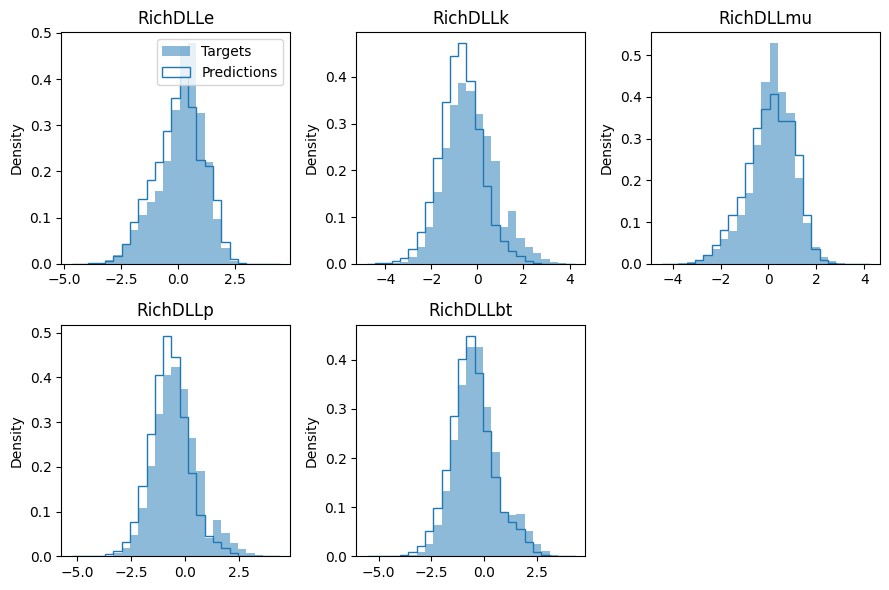

In [ ]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

The problem with `estimate_distances_and_plot_uncertainty_bins` is that it splits the data in unbalnced bins, with different sizes, some bins could get up to 30k samples while others get less than 20. Instead binning by quantiles generates a balanced number of observations per bin.

In [ ]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'linear',
                                                 particle_index = 0, n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    js_distances += [js_dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()
  print("Jensen–Shannon distances:\n" + ", ".join([str(dist) for dist in js_distances]))

  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.legend()
  plt.show()

## Monte Carlo Dropout method

In [ ]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]
mcd_uncertainty.shape

Generating ensemble(300) predictions


100%|██████████| 300/300 [05:20<00:00,  1.07s/it]


TensorShape([100000, 5])

In [ ]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

#### Linear bins

0.05 < unc. score < 0.11: Number of observations: 4944
0.11 < unc. score < 0.18: Number of observations: 6795
0.18 < unc. score < 0.24: Number of observations: 7196
0.24 < unc. score < 0.31: Number of observations: 14533
0.31 < unc. score < 0.38: Number of observations: 34433
0.38 < unc. score < 0.44: Number of observations: 25323
0.44 < unc. score < 0.51: Number of observations: 5998
0.51 < unc. score < 0.57: Number of observations: 715
0.57 < unc. score < 0.64: Number of observations: 58
0.64 < unc. score < 0.7: Number of observations: 4


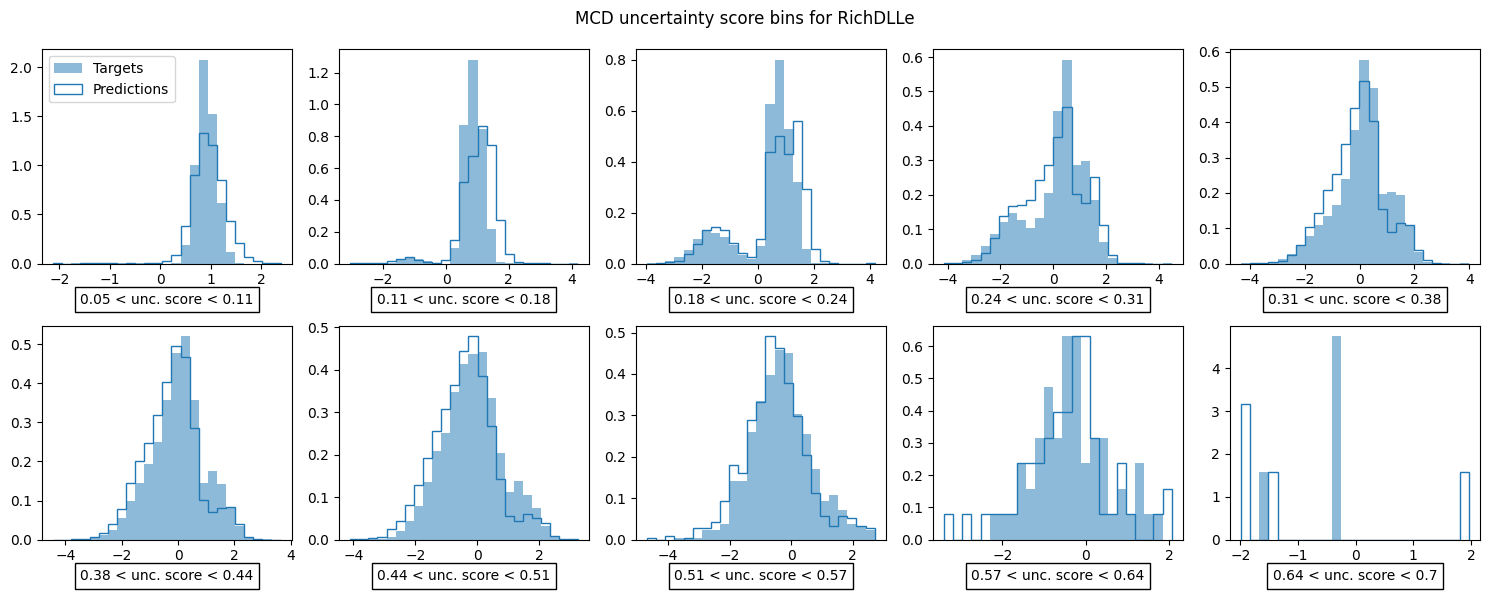

Jensen–Shannon distances:
0.21571245842594325, 0.2737207496093087, 0.19107164468003326, 0.1287077078554337, 0.11158062568821728, 0.10235628118789107, 0.1186457684200057, 0.1131165961454976, 0.28254593377671094, 0.8325546111576978
0.0 < unc. score < 0.11: Number of observations: 309
0.11 < unc. score < 0.21: Number of observations: 2073
0.21 < unc. score < 0.32: Number of observations: 19902
0.32 < unc. score < 0.43: Number of observations: 35213
0.43 < unc. score < 0.53: Number of observations: 30271
0.53 < unc. score < 0.64: Number of observations: 10089
0.64 < unc. score < 0.75: Number of observations: 1851
0.75 < unc. score < 0.85: Number of observations: 263
0.85 < unc. score < 0.96: Number of observations: 27
0.96 < unc. score < 1.06: Number of observations: 1


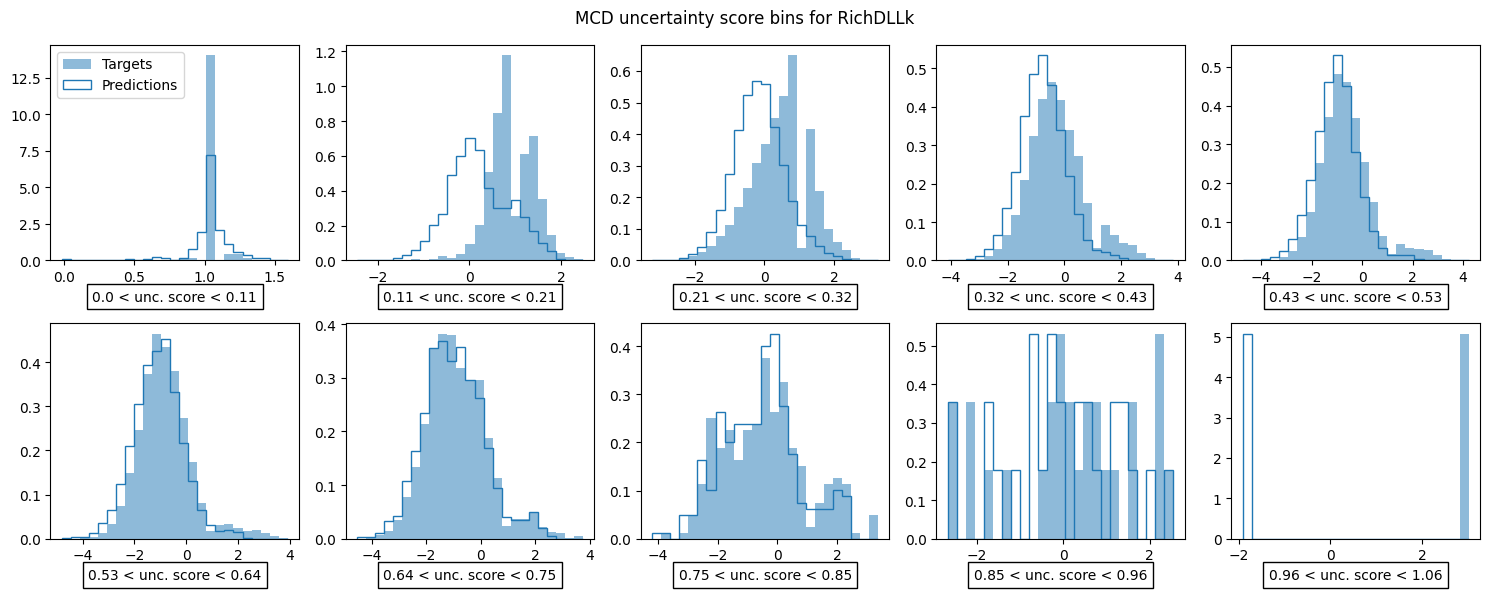

Jensen–Shannon distances:
0.4044445750875811, 0.45435484586592784, 0.2941702451307388, 0.20463666387209062, 0.15378428513319156, 0.11824081613771792, 0.07366605019279251, 0.1607844489959294, 0.48751738072038353, 0.8325546111576977
0.0 < unc. score < 0.11: Number of observations: 8526
0.11 < unc. score < 0.22: Number of observations: 11245
0.22 < unc. score < 0.32: Number of observations: 11906
0.32 < unc. score < 0.43: Number of observations: 13198
0.43 < unc. score < 0.53: Number of observations: 17364
0.53 < unc. score < 0.64: Number of observations: 21766
0.64 < unc. score < 0.74: Number of observations: 11986
0.74 < unc. score < 0.85: Number of observations: 3421
0.85 < unc. score < 0.96: Number of observations: 545
0.96 < unc. score < 1.06: Number of observations: 42


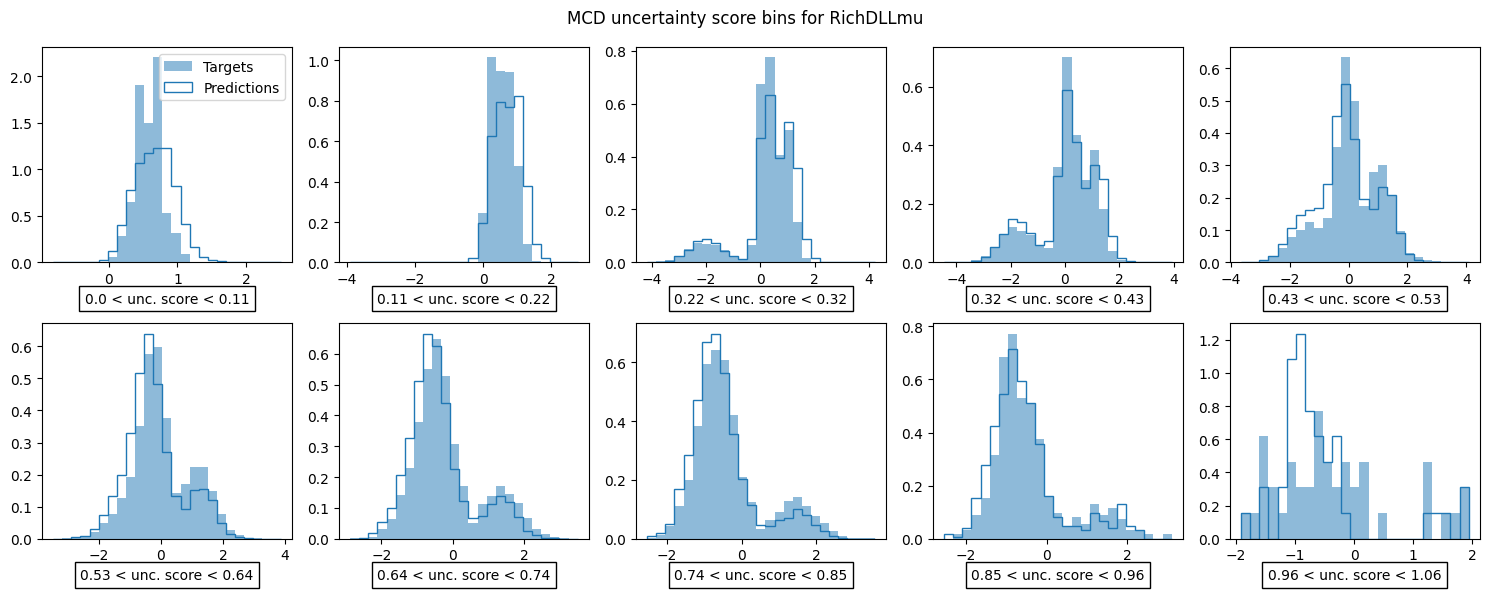

Jensen–Shannon distances:
0.2371243412049867, 0.1928538020950167, 0.13732138392074109, 0.0836891851584548, 0.10802477031880031, 0.12382032074324623, 0.10897045522094977, 0.09009478572646072, 0.1166985061662501, 0.39325718253874237
0.0 < unc. score < 0.12: Number of observations: 346
0.12 < unc. score < 0.24: Number of observations: 925
0.24 < unc. score < 0.37: Number of observations: 10449
0.37 < unc. score < 0.49: Number of observations: 37595
0.49 < unc. score < 0.61: Number of observations: 33937
0.61 < unc. score < 0.73: Number of observations: 13000
0.73 < unc. score < 0.85: Number of observations: 2964
0.85 < unc. score < 0.97: Number of observations: 644
0.97 < unc. score < 1.1: Number of observations: 130
1.1 < unc. score < 1.22: Number of observations: 9


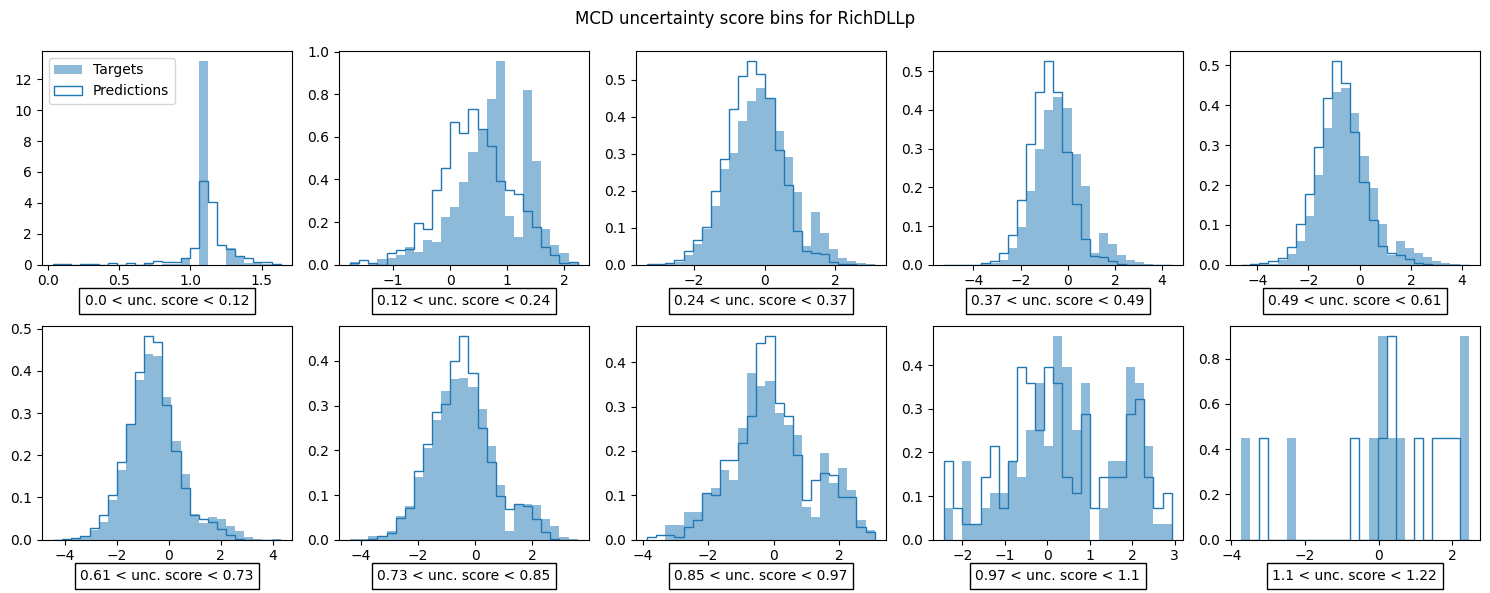

Jensen–Shannon distances:
0.4667304437237982, 0.252495997278381, 0.13516147395242442, 0.1892067072080946, 0.13154089366035818, 0.07377796586839713, 0.10163280413759121, 0.11796384687067432, 0.22581511207467414, 0.6935241913091122
0.0 < unc. score < 0.22: Number of observations: 741
0.22 < unc. score < 0.44: Number of observations: 12354
0.44 < unc. score < 0.66: Number of observations: 36545
0.66 < unc. score < 0.87: Number of observations: 26253
0.87 < unc. score < 1.09: Number of observations: 16509
1.09 < unc. score < 1.31: Number of observations: 6375
1.31 < unc. score < 1.53: Number of observations: 1091
1.53 < unc. score < 1.75: Number of observations: 115
1.75 < unc. score < 1.96: Number of observations: 13
1.96 < unc. score < 2.18: Number of observations: 3


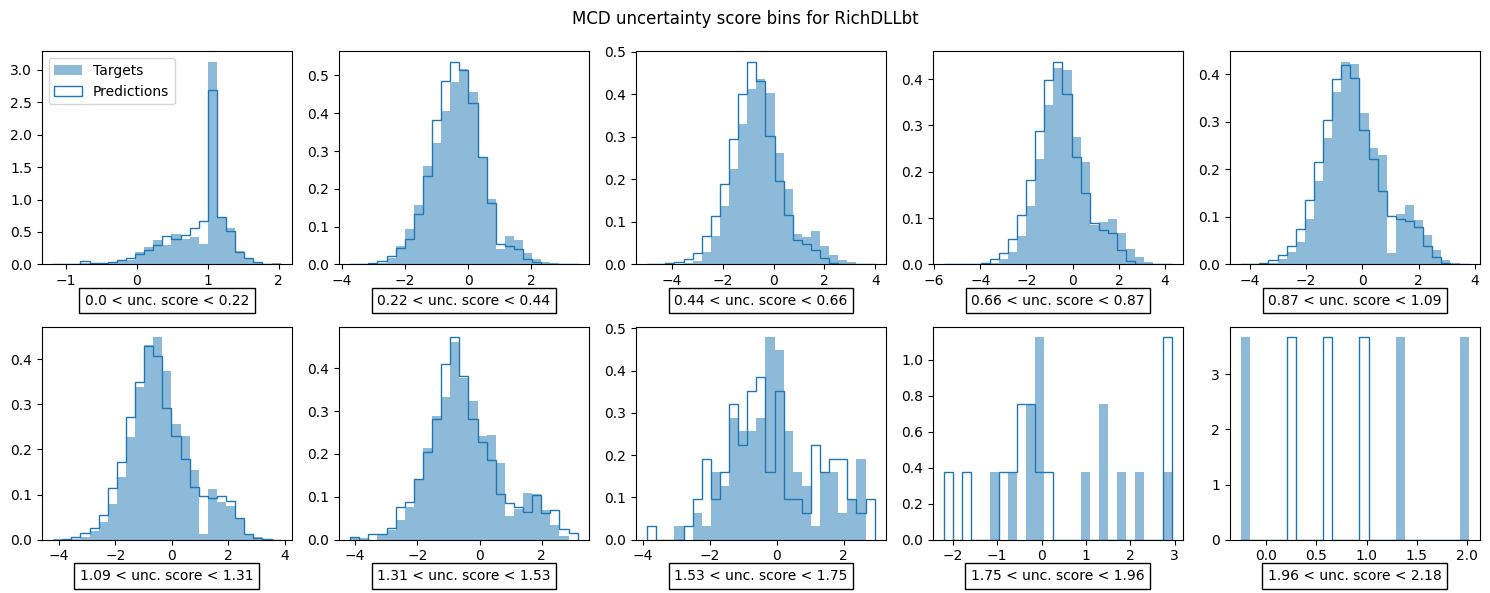

Jensen–Shannon distances:
0.10458619033203927, 0.07035365133018275, 0.1305034314511184, 0.11507876262192526, 0.10052622109014983, 0.10186755263946205, 0.09661961823174217, 0.26620906834700203, 0.6001366251333453, 0.8325546111576978


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.43238688742003734
Correlation coefficient for RichDLLk: 0.2365007338049561
Correlation coefficient for RichDLLmu: 0.1406103693807589
Correlation coefficient for RichDLLp: 0.13580906344784052
Correlation coefficient for RichDLLbt: 0.7638785126343371


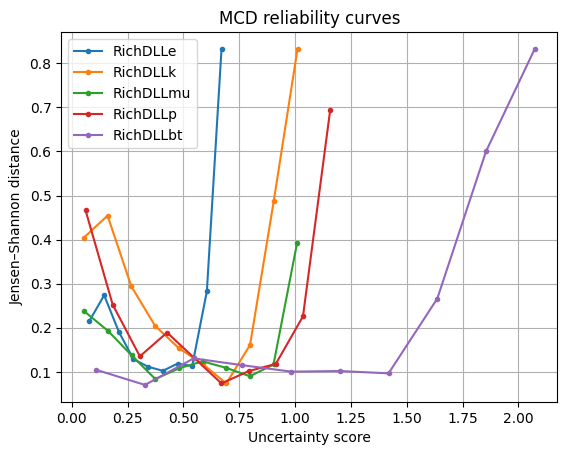

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### Quantile bins

0.05 < unc. score < 0.16: Number of observations: 10000
0.16 < unc. score < 0.25: Number of observations: 10000
0.25 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.34: Number of observations: 10000
0.34 < unc. score < 0.36: Number of observations: 10000
0.36 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.43: Number of observations: 10000
0.43 < unc. score < 0.7: Number of observations: 9999


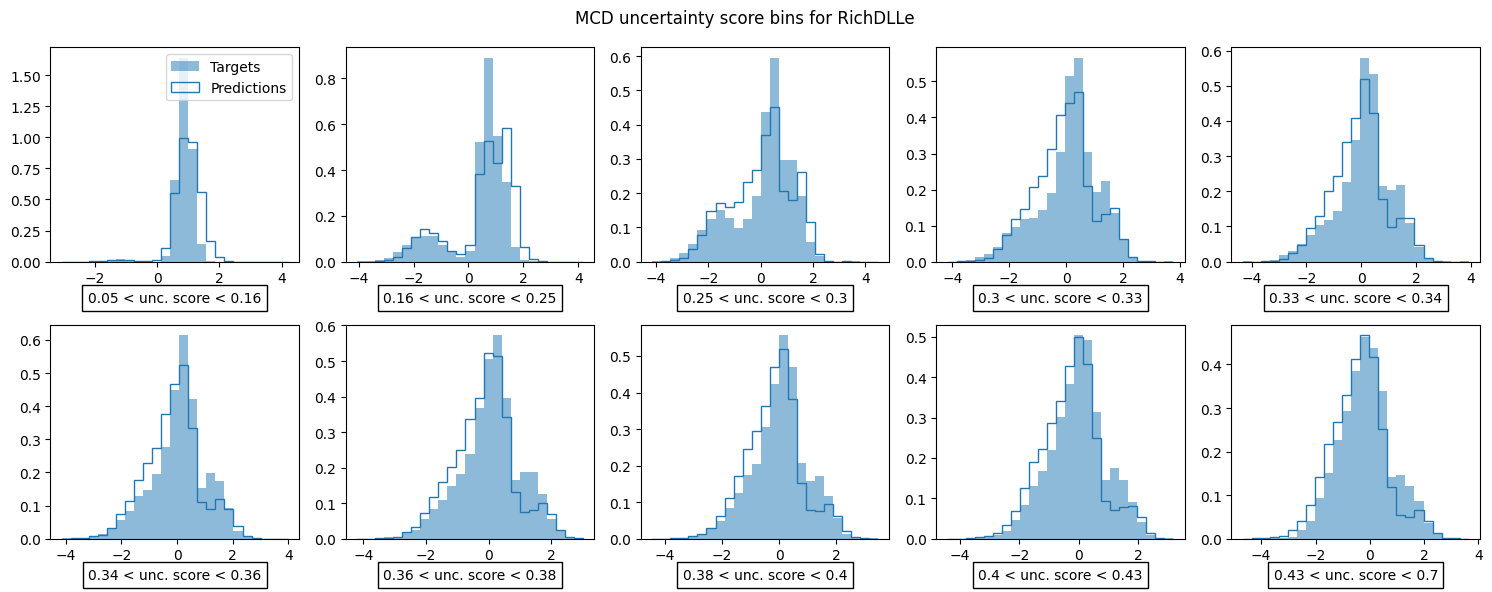

Jensen–Shannon distances:
0.2303948078863598, 0.20183219943725542, 0.12923920231953773, 0.12136363375534005, 0.11968644943871042, 0.11036667633214883, 0.1100710100349054, 0.10514141179653938, 0.10484989714274258, 0.11545576867196992
0.0 < unc. score < 0.27: Number of observations: 10000
0.27 < unc. score < 0.31: Number of observations: 10000
0.31 < unc. score < 0.35: Number of observations: 10000
0.35 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.43: Number of observations: 10000
0.43 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 1.06: Number of observations: 9999


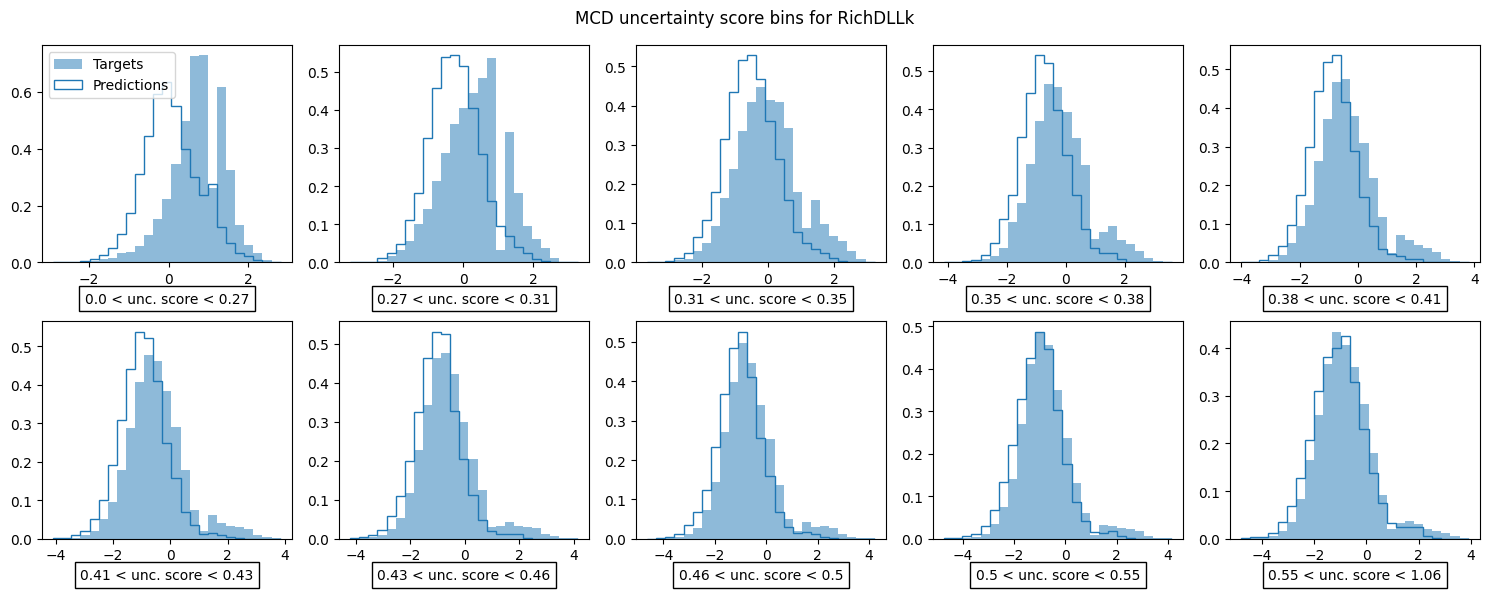

Jensen–Shannon distances:
0.3558776769228404, 0.26421298352701794, 0.2159023258304543, 0.21646264574056517, 0.20562838883864354, 0.19210239647133615, 0.16862590957922444, 0.1534463019582631, 0.12795165074790857, 0.10509388916431783
0.0 < unc. score < 0.12: Number of observations: 10000
0.12 < unc. score < 0.22: Number of observations: 10000
0.22 < unc. score < 0.31: Number of observations: 10000
0.31 < unc. score < 0.39: Number of observations: 10000
0.39 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.57: Number of observations: 10000
0.57 < unc. score < 0.62: Number of observations: 10000
0.62 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 1.06: Number of observations: 9999


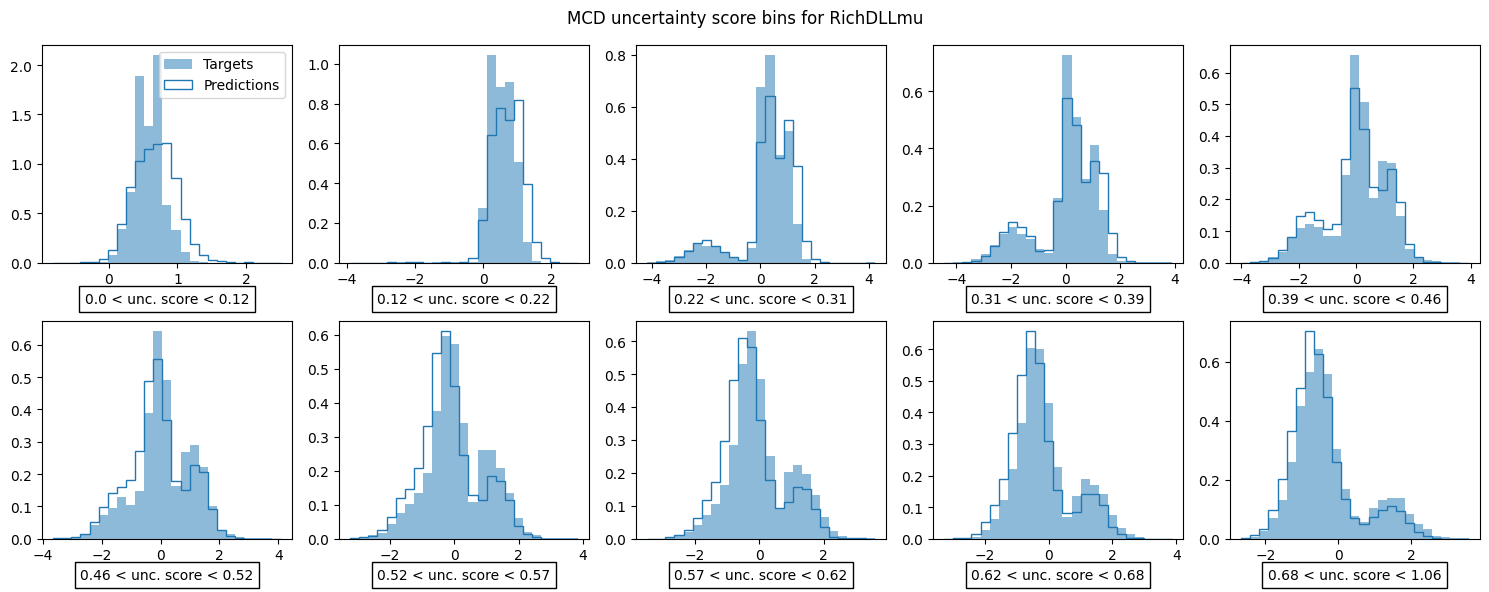

Jensen–Shannon distances:
0.2310892759581835, 0.19176225167501465, 0.14297970922790737, 0.10350763750538314, 0.08061559180866015, 0.11516520289957746, 0.12972741444857347, 0.1323027124760205, 0.11386463565038331, 0.09549763194704901
0.0 < unc. score < 0.36: Number of observations: 10000
0.36 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.43: Number of observations: 10000
0.43 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.49: Number of observations: 10000
0.49 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.59: Number of observations: 10000
0.59 < unc. score < 0.65: Number of observations: 10000
0.65 < unc. score < 1.22: Number of observations: 9999


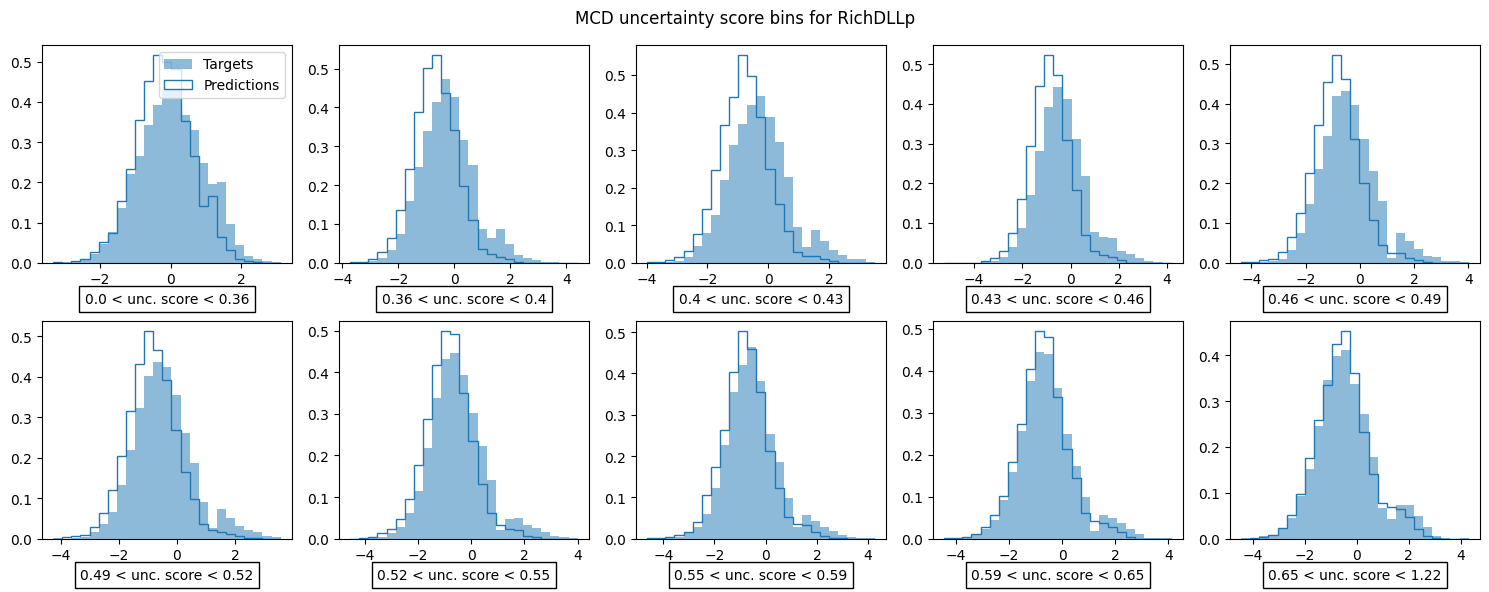

Jensen–Shannon distances:
0.1284632995513097, 0.1796443806178528, 0.20279043369701338, 0.19492535090447624, 0.18067290347005888, 0.15899205826004864, 0.14014444668951404, 0.11444616993027454, 0.08973533678878508, 0.07072239672380543
0.0 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.48: Number of observations: 10000
0.48 < unc. score < 0.54: Number of observations: 10000
0.54 < unc. score < 0.59: Number of observations: 10000
0.59 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.82: Number of observations: 10000
0.82 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 1.05: Number of observations: 10000
1.05 < unc. score < 2.18: Number of observations: 9999


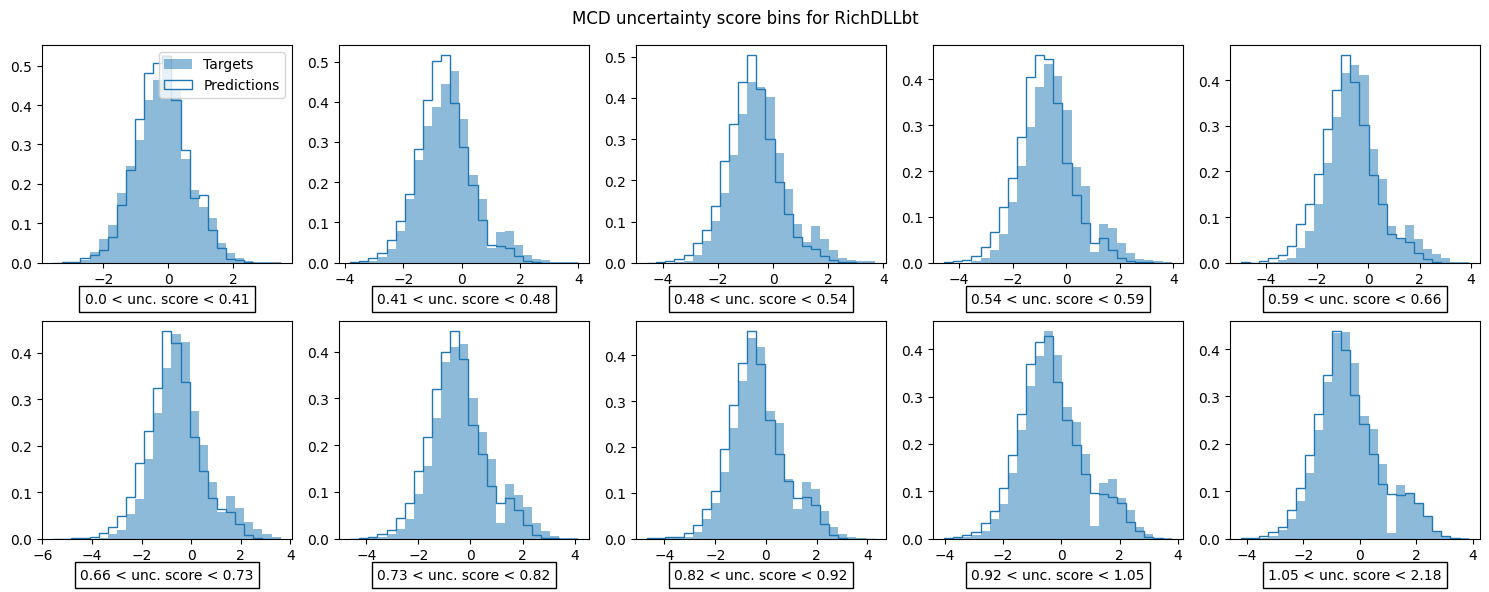

Jensen–Shannon distances:
0.0647273729448661, 0.10654430538801474, 0.1320542239205858, 0.15072939743908406, 0.14198957168996196, 0.13602403659208212, 0.11793588081702075, 0.09417707154025569, 0.09548177511077625, 0.09744664523951468


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: -0.8134196808087237
Correlation coefficient for RichDLLk: -0.9132361763906021
Correlation coefficient for RichDLLmu: -0.7336680421958046
Correlation coefficient for RichDLLp: -0.6181558210859135
Correlation coefficient for RichDLLbt: -0.08402661210268676


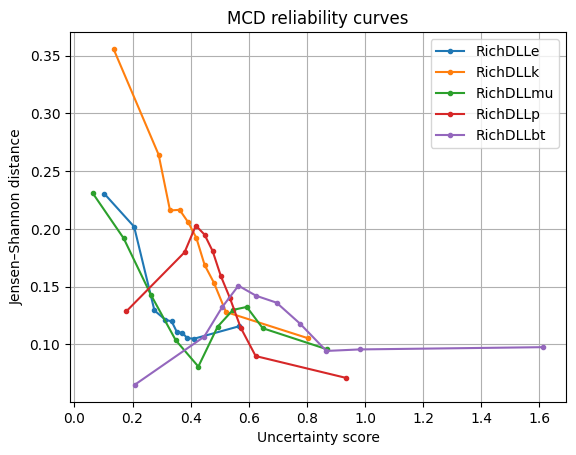

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

## Feature Densities method

### Generation of FD embeddings

In [ ]:
from feature_densities.feature_density_evaluator import create_embeddings_model
embeddings_model = create_embeddings_model(model)

train_embeddings = embeddings_model.predict(dataset['feats_train'])[0]

!rm -r embeddings
!mkdir embeddings

np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)

29637/29637 [==============================] - 58s 2ms/step


### Uncertainty estimation

In [ ]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948359, 128)

In [ ]:
fd_uncertainty_normalized, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                 likelihood_method='normalized')

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 11s 3ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:37<00:00,  3.43it/s]

Feature Densities using NORMALIZED uncertainty score for x_sample:


TensorShape([100000])

In [ ]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

### Plot FD uncertainties

#### Linear bins

0.05 < unc. score < 0.14: Number of observations: 2469
0.14 < unc. score < 0.22: Number of observations: 6441
0.22 < unc. score < 0.31: Number of observations: 8607
0.31 < unc. score < 0.4: Number of observations: 11850
0.4 < unc. score < 0.49: Number of observations: 15069
0.49 < unc. score < 0.58: Number of observations: 17071
0.58 < unc. score < 0.67: Number of observations: 15875
0.67 < unc. score < 0.76: Number of observations: 12963
0.76 < unc. score < 0.85: Number of observations: 8404
0.85 < unc. score < 0.93: Number of observations: 1250


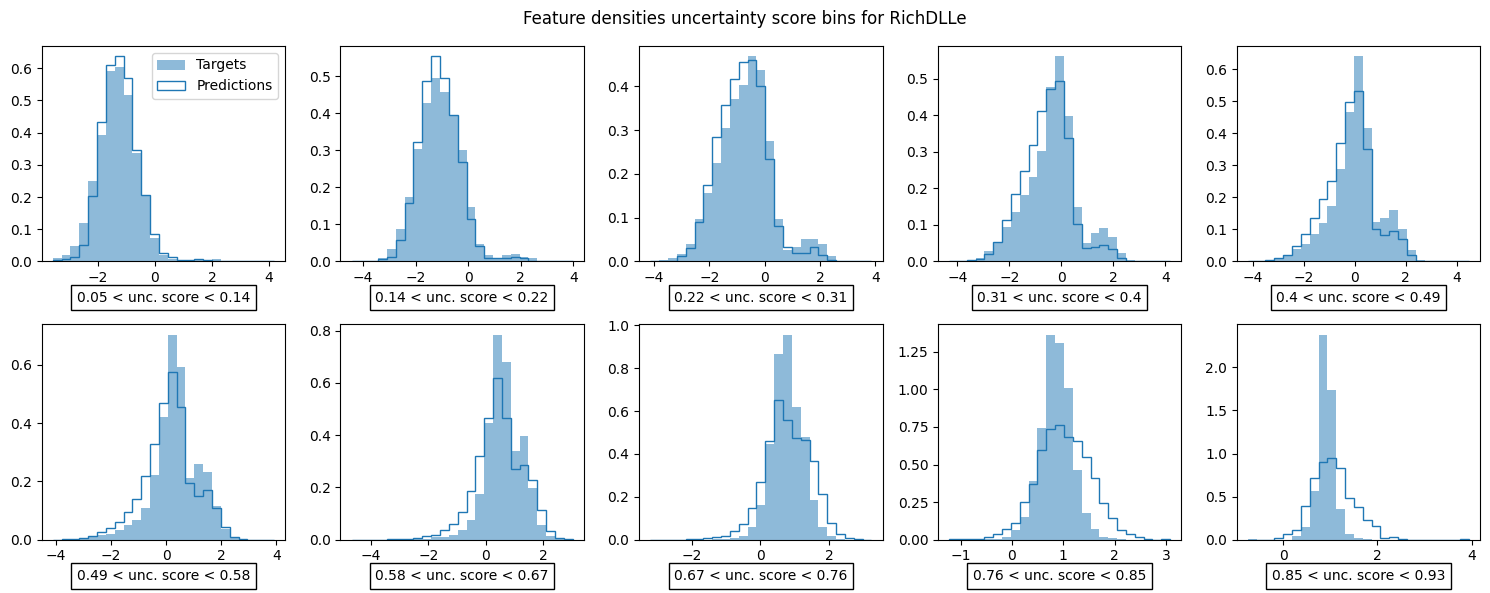

Jensen–Shannon distances:
0.08456507146933576, 0.06351063171665142, 0.07824510285561884, 0.1005644554076663, 0.1032421548901895, 0.12465774405152752, 0.15419346662458253, 0.18758618035834776, 0.26087584661092694, 0.3597244341355215
0.05 < unc. score < 0.14: Number of observations: 2469
0.14 < unc. score < 0.22: Number of observations: 6441
0.22 < unc. score < 0.31: Number of observations: 8607
0.31 < unc. score < 0.4: Number of observations: 11850
0.4 < unc. score < 0.49: Number of observations: 15069
0.49 < unc. score < 0.58: Number of observations: 17071
0.58 < unc. score < 0.67: Number of observations: 15875
0.67 < unc. score < 0.76: Number of observations: 12963
0.76 < unc. score < 0.85: Number of observations: 8404
0.85 < unc. score < 0.93: Number of observations: 1250


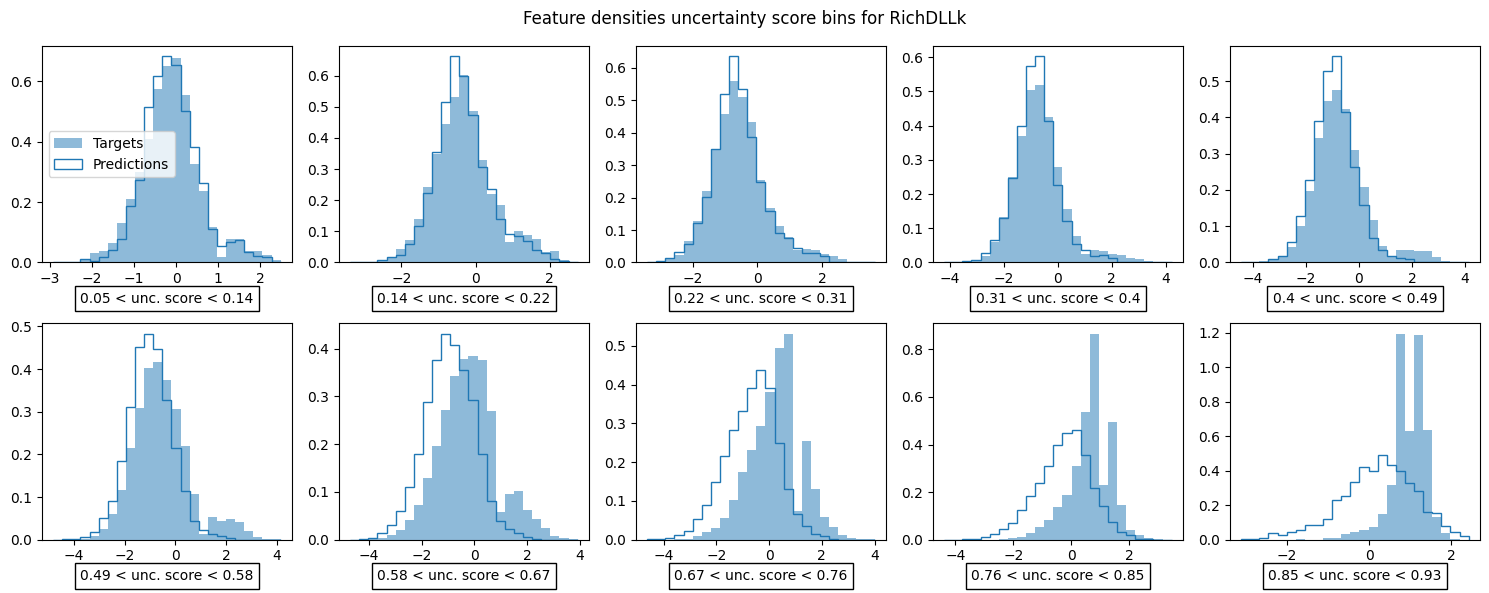

Jensen–Shannon distances:
0.07884658230633566, 0.06886528403037705, 0.06625473992479121, 0.09104674915667514, 0.1253379336614952, 0.18137187583885978, 0.25590992431757537, 0.3279444123127755, 0.3825484394154078, 0.4447662929025117
0.05 < unc. score < 0.14: Number of observations: 2469
0.14 < unc. score < 0.22: Number of observations: 6441
0.22 < unc. score < 0.31: Number of observations: 8607
0.31 < unc. score < 0.4: Number of observations: 11850
0.4 < unc. score < 0.49: Number of observations: 15069
0.49 < unc. score < 0.58: Number of observations: 17071
0.58 < unc. score < 0.67: Number of observations: 15875
0.67 < unc. score < 0.76: Number of observations: 12963
0.76 < unc. score < 0.85: Number of observations: 8404
0.85 < unc. score < 0.93: Number of observations: 1250


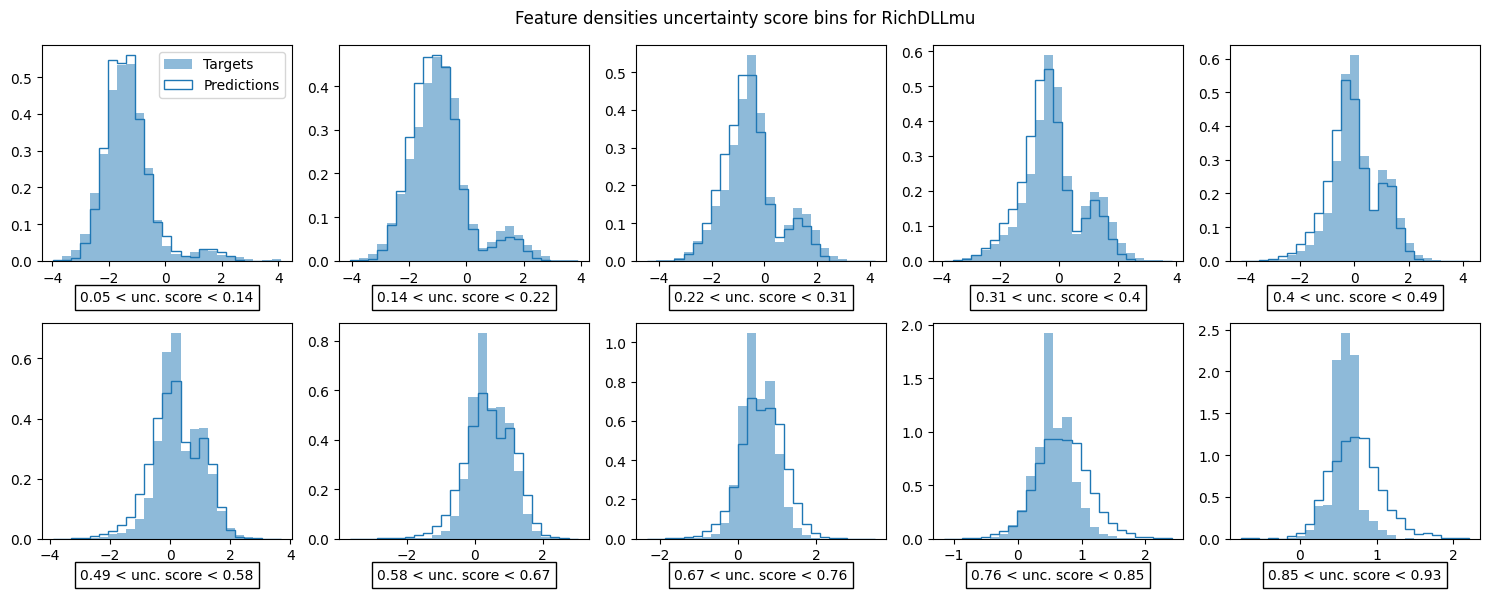

Jensen–Shannon distances:
0.08231274321404496, 0.0772976413193241, 0.09286976018253441, 0.1061138553794713, 0.09999972859406402, 0.11522292591812046, 0.1302348177480125, 0.1594076065556777, 0.21689825275824118, 0.3349247291912266
0.05 < unc. score < 0.14: Number of observations: 2469
0.14 < unc. score < 0.22: Number of observations: 6441
0.22 < unc. score < 0.31: Number of observations: 8607
0.31 < unc. score < 0.4: Number of observations: 11850
0.4 < unc. score < 0.49: Number of observations: 15069
0.49 < unc. score < 0.58: Number of observations: 17071
0.58 < unc. score < 0.67: Number of observations: 15875
0.67 < unc. score < 0.76: Number of observations: 12963
0.76 < unc. score < 0.85: Number of observations: 8404
0.85 < unc. score < 0.93: Number of observations: 1250


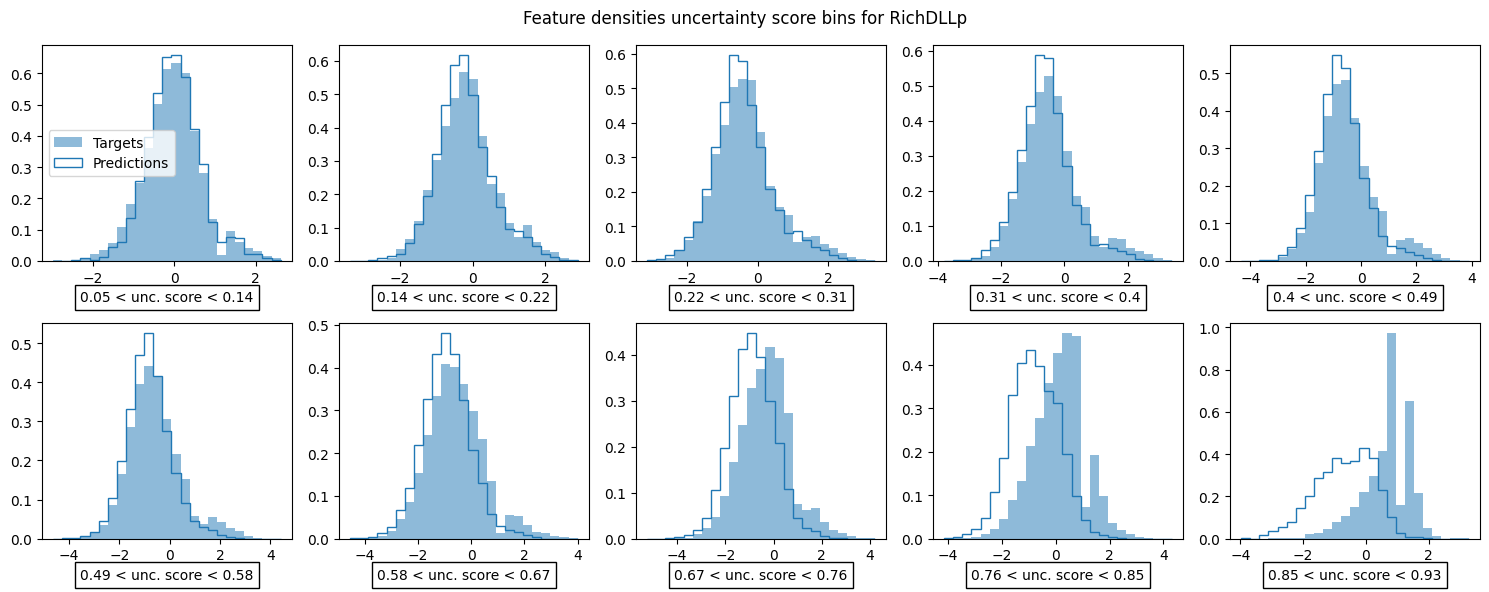

Jensen–Shannon distances:
0.07505688872232281, 0.06605068424406091, 0.08047385043506605, 0.09790678966677278, 0.11252815955237216, 0.11195085617340841, 0.1419022795902598, 0.2073184651948003, 0.3331022879189911, 0.5169253750523405
0.05 < unc. score < 0.14: Number of observations: 2469
0.14 < unc. score < 0.22: Number of observations: 6441
0.22 < unc. score < 0.31: Number of observations: 8607
0.31 < unc. score < 0.4: Number of observations: 11850
0.4 < unc. score < 0.49: Number of observations: 15069
0.49 < unc. score < 0.58: Number of observations: 17071
0.58 < unc. score < 0.67: Number of observations: 15875
0.67 < unc. score < 0.76: Number of observations: 12963
0.76 < unc. score < 0.85: Number of observations: 8404
0.85 < unc. score < 0.93: Number of observations: 1250


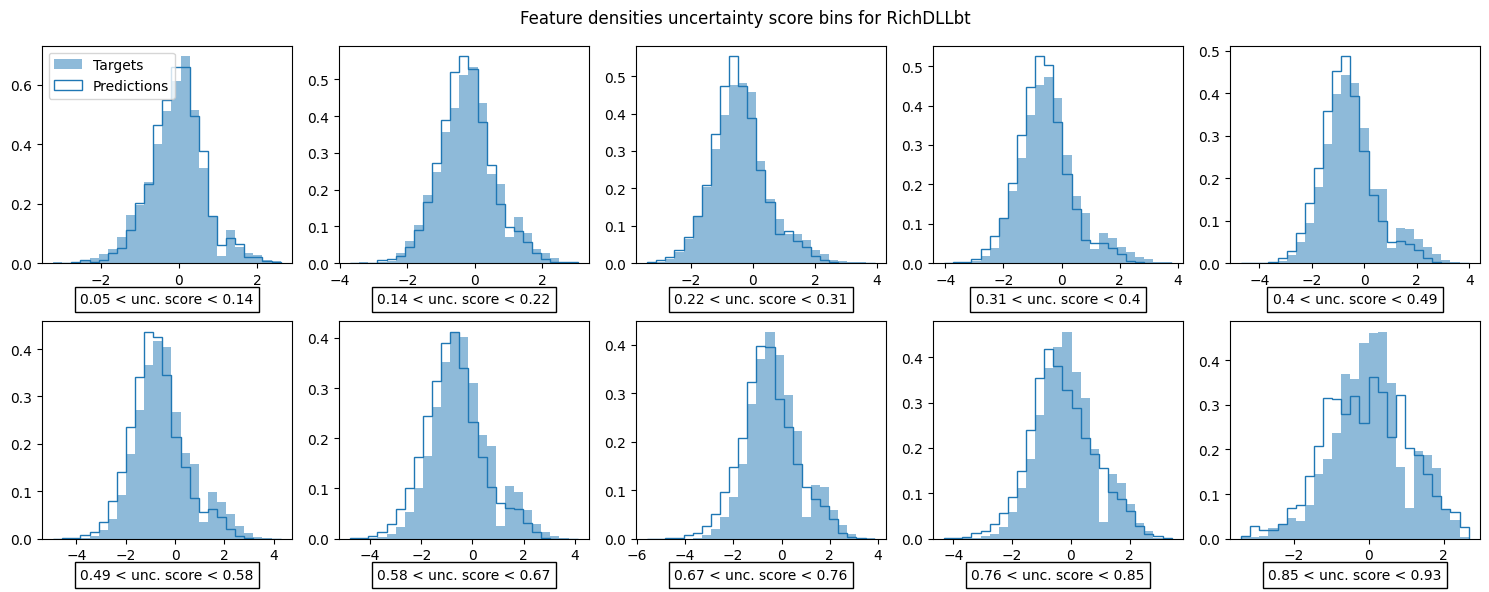

Jensen–Shannon distances:
0.07585806822393935, 0.07031917055095441, 0.0730512721657769, 0.10590819924719783, 0.10860915812436517, 0.12130926034554397, 0.13510835727074813, 0.1293902473478083, 0.13109978852838175, 0.15973757920933454


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.8935147578229937
Correlation coefficient for RichDLLk: 0.9528042288528021
Correlation coefficient for RichDLLmu: 0.8449402021826518
Correlation coefficient for RichDLLp: 0.8379610268611895
Correlation coefficient for RichDLLbt: 0.9517130070737788


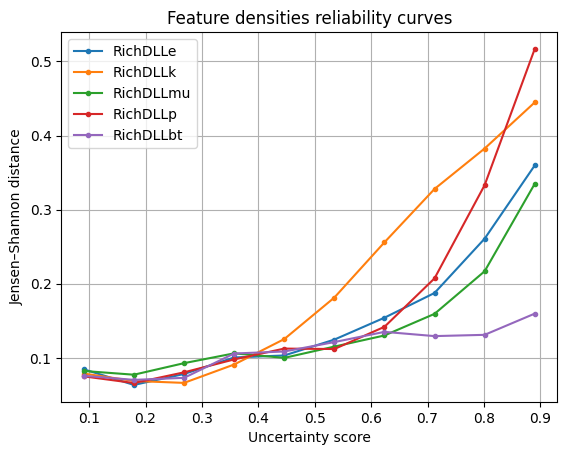

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

#### Quantile bins

0.05 < unc. score < 0.24: Number of observations: 10000
0.24 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.57: Number of observations: 10000
0.57 < unc. score < 0.62: Number of observations: 10000
0.62 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.93: Number of observations: 9999


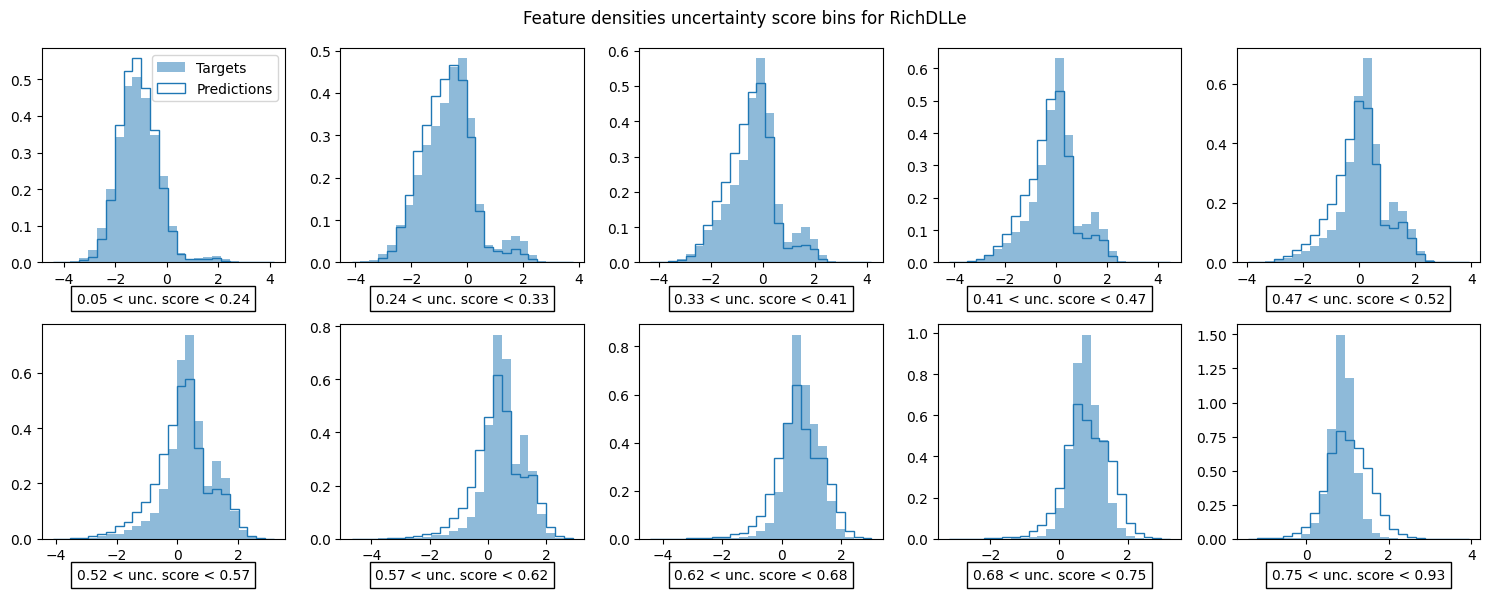

Jensen–Shannon distances:
0.05907282938578148, 0.0833151136463558, 0.10060758317355376, 0.10187042775446864, 0.11668191321026039, 0.13109921579142927, 0.15175548905337644, 0.16353300699207238, 0.1913144033227347, 0.26225649733338985
0.05 < unc. score < 0.24: Number of observations: 10000
0.24 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.57: Number of observations: 10000
0.57 < unc. score < 0.62: Number of observations: 10000
0.62 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.93: Number of observations: 9999


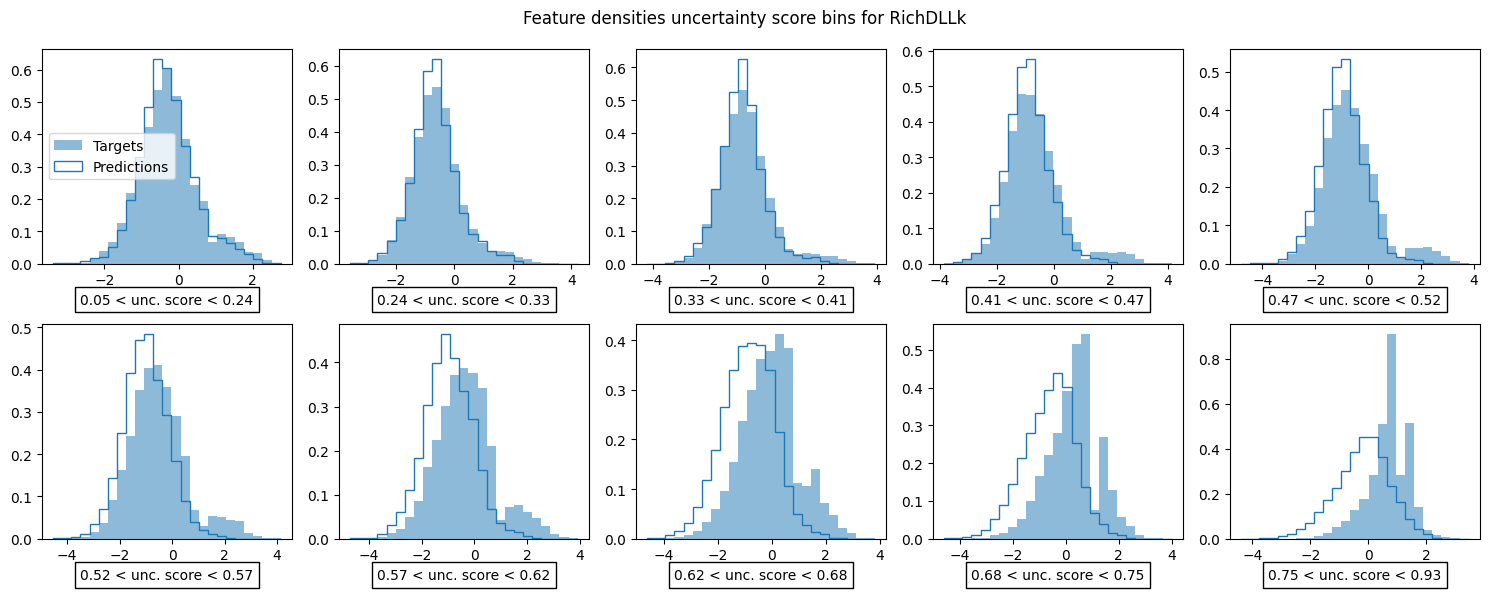

Jensen–Shannon distances:
0.058395510581365107, 0.06859248868097491, 0.0926870646375151, 0.12497658763875977, 0.14676378849217672, 0.1852628586499005, 0.23363736166638757, 0.28429335072415163, 0.3329872323290868, 0.37943240482063406
0.05 < unc. score < 0.24: Number of observations: 10000
0.24 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.57: Number of observations: 10000
0.57 < unc. score < 0.62: Number of observations: 10000
0.62 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.93: Number of observations: 9999


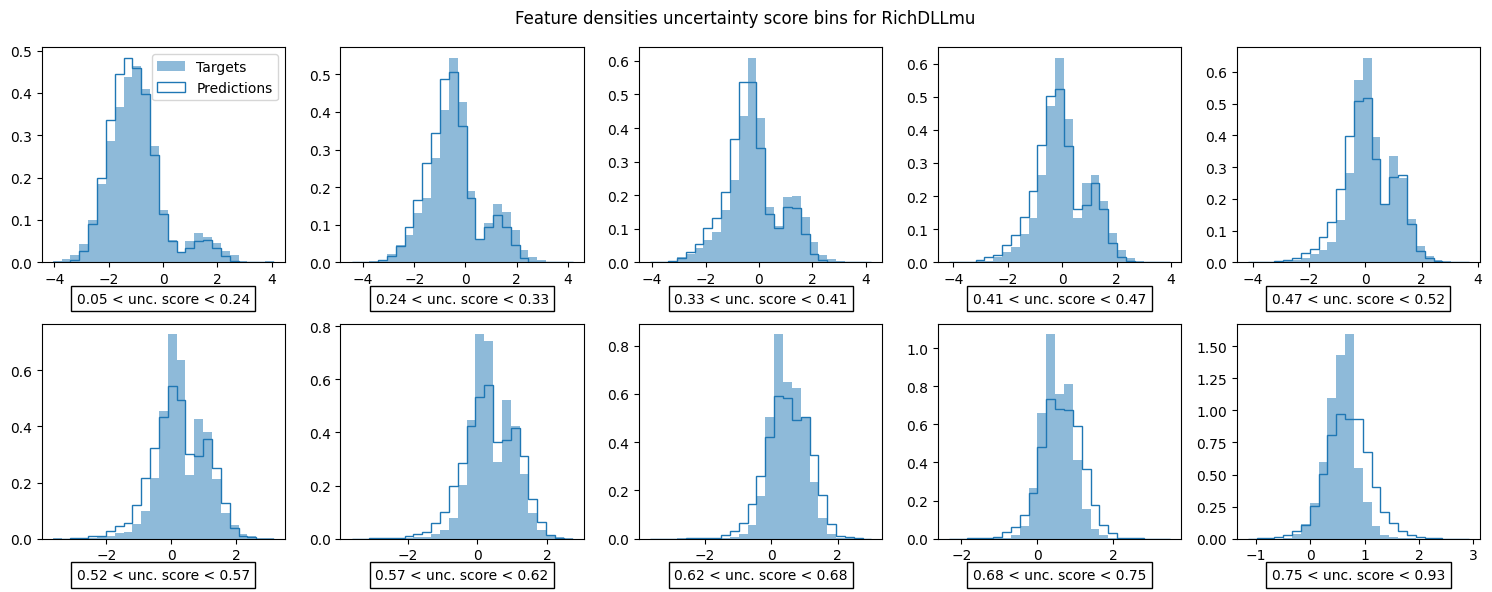

Jensen–Shannon distances:
0.07129374421062523, 0.09689586212203556, 0.10693292896706422, 0.10156945313196544, 0.10479684142408618, 0.12516854796011279, 0.13426130240470835, 0.13986683197977445, 0.16163651873072812, 0.2191255690704483
0.05 < unc. score < 0.24: Number of observations: 10000
0.24 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.57: Number of observations: 10000
0.57 < unc. score < 0.62: Number of observations: 10000
0.62 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.93: Number of observations: 9999


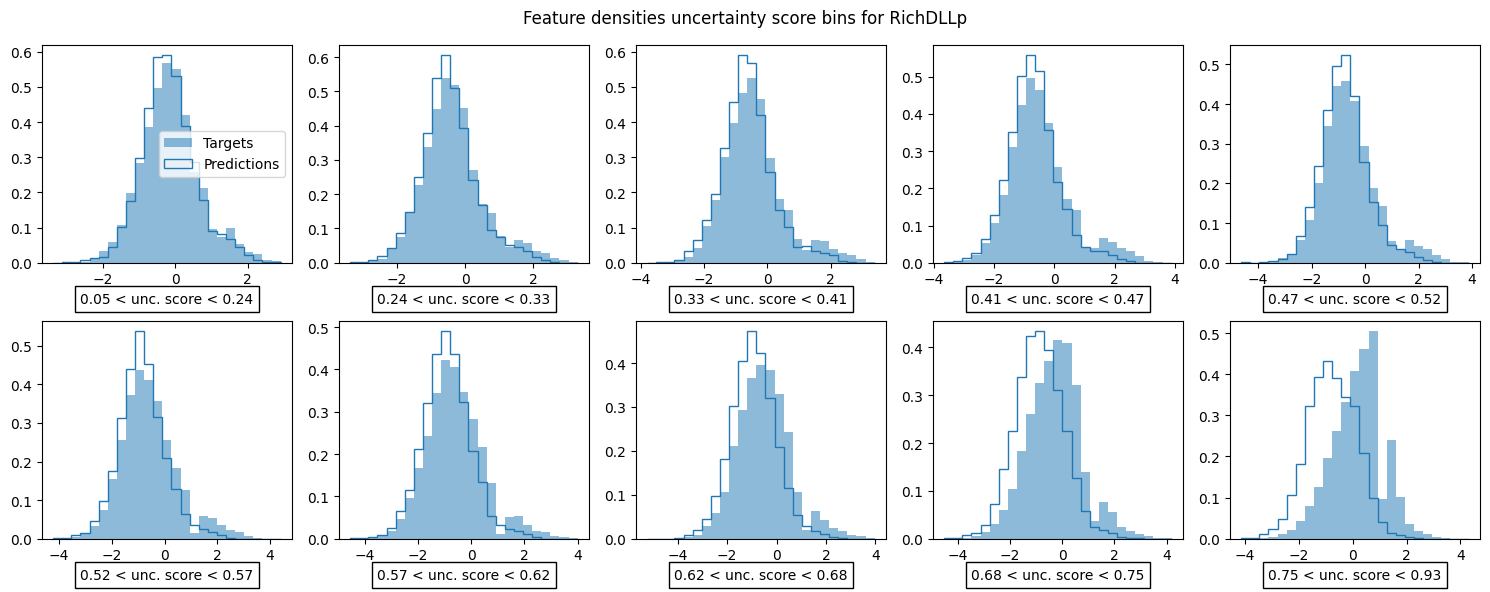

Jensen–Shannon distances:
0.06102781456937902, 0.07643817220522124, 0.09938338630668953, 0.11002874439581904, 0.1025148598648014, 0.12517352224282347, 0.13221351011808682, 0.16287817842081984, 0.2141096335625596, 0.3489292618323786
0.05 < unc. score < 0.24: Number of observations: 10000
0.24 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.57: Number of observations: 10000
0.57 < unc. score < 0.62: Number of observations: 10000
0.62 < unc. score < 0.68: Number of observations: 10000
0.68 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.93: Number of observations: 9999


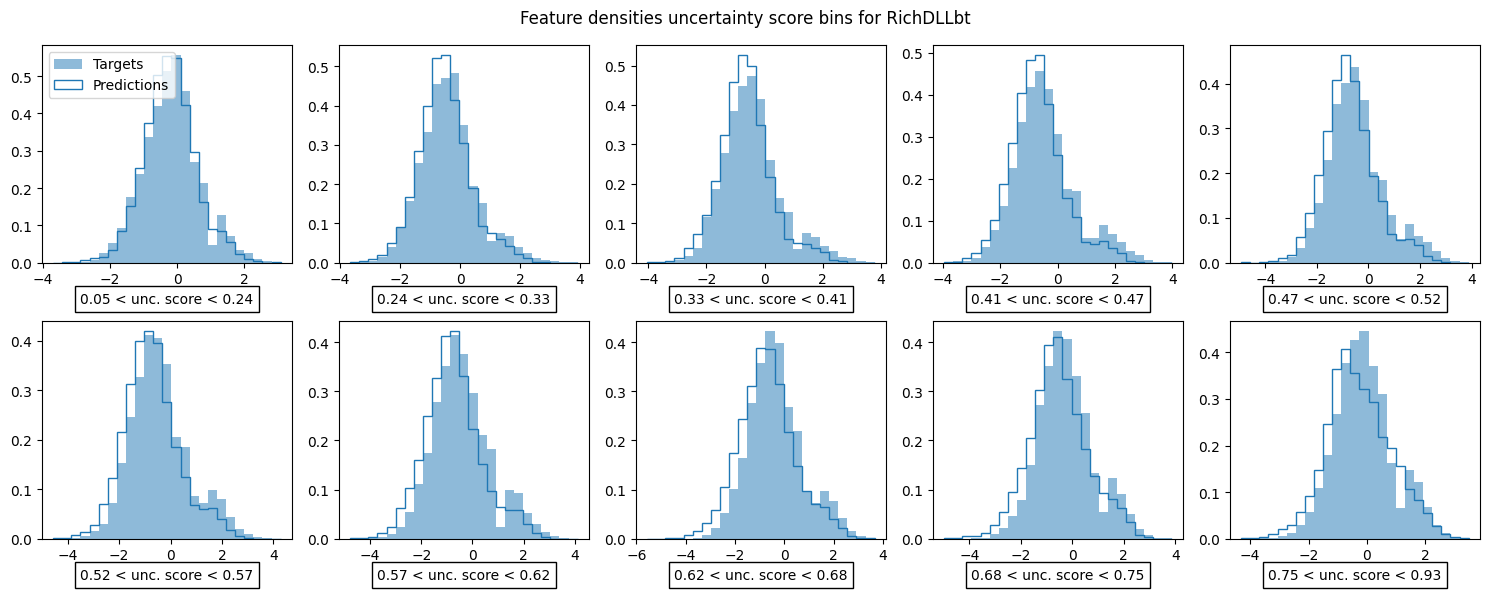

Jensen–Shannon distances:
0.07333994734604983, 0.08108867568000724, 0.10781911556619377, 0.10821741151845601, 0.1067314007320499, 0.11687849747812311, 0.13421815749221852, 0.12594084268100084, 0.11856180133815239, 0.12018401027160525


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9561571857559401
Correlation coefficient for RichDLLk: 0.9626081759195805
Correlation coefficient for RichDLLmu: 0.9296122858878227
Correlation coefficient for RichDLLp: 0.8738811130418924
Correlation coefficient for RichDLLbt: 0.8443561468692995


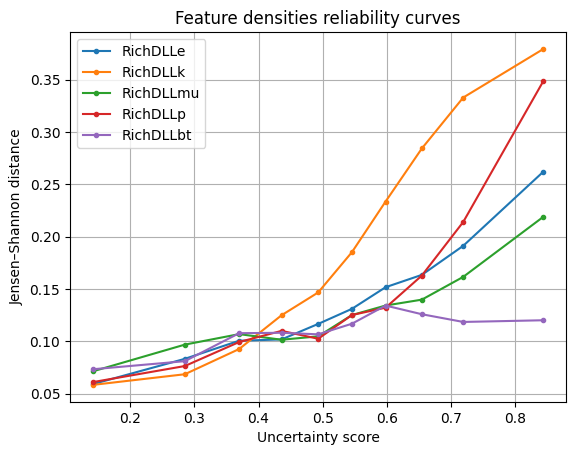

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

## Uncertainty heatmaps

In [ ]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

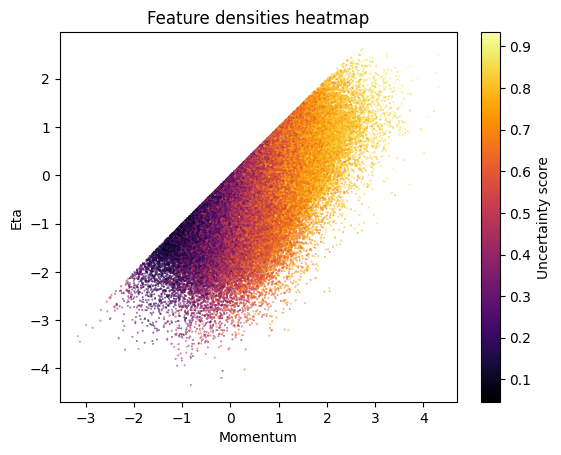

In [ ]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap, 'inferno')
  plt.gca().invert_yaxis()
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

<ipython-input-30-97c69ed682c3>:16: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


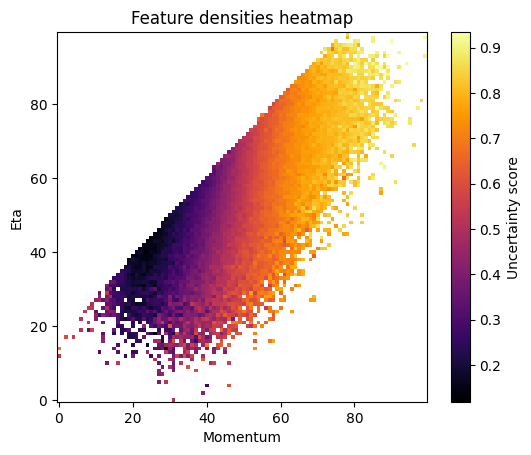

In [ ]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

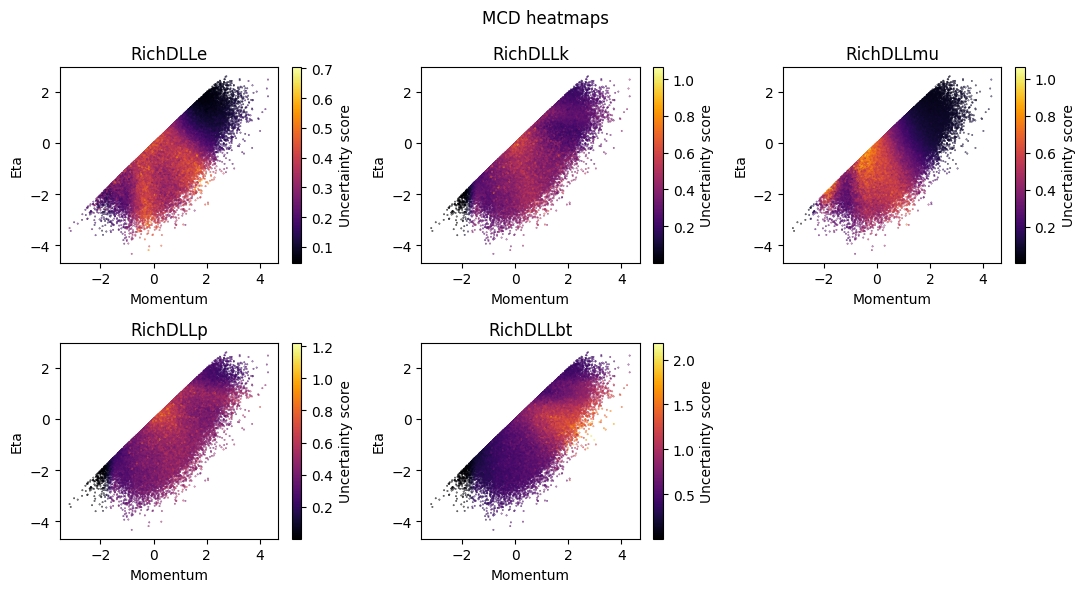

In [ ]:
uncertainty_scatter_plot_mcd(x_sample, mcd_uncertainty)

In [ ]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap, 'inferno')
    ax.invert_yaxis()
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

<ipython-input-34-e99db391306d>:19: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


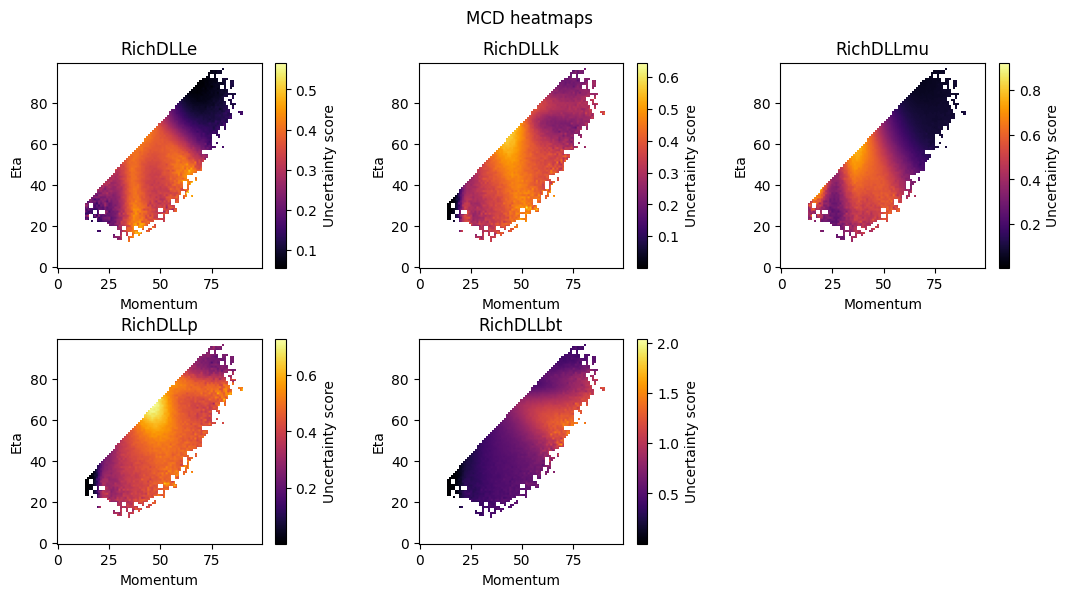

In [ ]:
uncertainty_hist2d_mcd(x_sample, mcd_uncertainty)

# Efficiency plots

In [ ]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

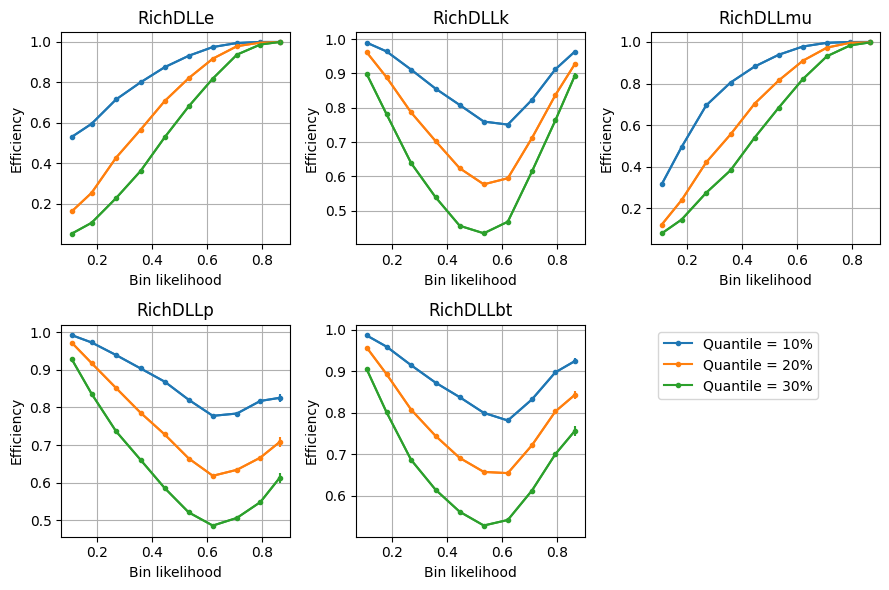

In [ ]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

##Plot Efficiencies by particle

In [ ]:
def plot_efficiencies_by_particle(y_sample, t_generated, uncertainties, quantiles, uncertainty_type="MCD", particle_idx=0, n_bins=10, dll_columns=DLL_COLUMNS):
    y_sample = np.array(y_sample)
    t_generated = np.array(t_generated)
    uncertainties = np.array(uncertainties)

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    colors = plt.colormaps['tab10']

    if uncertainty_type == "MCD":
        uncertainties_column = uncertainties[:, particle_idx]
    else:
        uncertainties_column = uncertainties


    bin_edges = np.quantile(uncertainties_column, np.linspace(0, 1, n_bins + 1))
    indices = np.digitize(uncertainties_column, bin_edges, right=True)

    bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
    bins_real = [y_sample[indices == i] for i in range(1, n_bins + 1)]
    bins_likelihoods = [uncertainties_column[indices == i].mean() for i in range(1, n_bins + 1)]

    for idx, ax in zip(range(len(quantiles)), axes.flatten()):
        quantile = quantiles[idx]
        threshold = select_threshold(y_sample[:, particle_idx], quantile)

        eff_gen, err_gen = efficiency_bins(bins_targets, threshold, particle_idx)
        eff_real, err_real = efficiency_bins(bins_real, threshold, particle_idx)



        ax.plot(bins_likelihoods, eff_gen, '.-', color=colors(0), label='Generated')

        ax.fill_between(bins_likelihoods, np.array(eff_gen) - np.array(err_gen),
                        np.array(eff_gen) + np.array(err_gen), color=colors(0), alpha=0.3)

        ax.plot(bins_likelihoods, eff_real, '.-', color=colors(20), label='Real')

        ax.fill_between(bins_likelihoods, np.array(eff_real) - np.array(err_real),
                        np.array(eff_real) + np.array(err_real), color=colors(20), alpha=0.3)

        ax.set_title(f'Threshold {int(quantile * 100)}%')
        ax.set_axisbelow(True)
        ax.grid()
        ax.set_xlabel("Uncertainty Score")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1.10)

    axes[-1, -1].axis(False)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize='small')

    plt.suptitle(f'{uncertainty_type} efficiencies plot for {dll_columns[particle_idx]}')

    plt.tight_layout()
    plt.show()

### Plot FD efficiencies

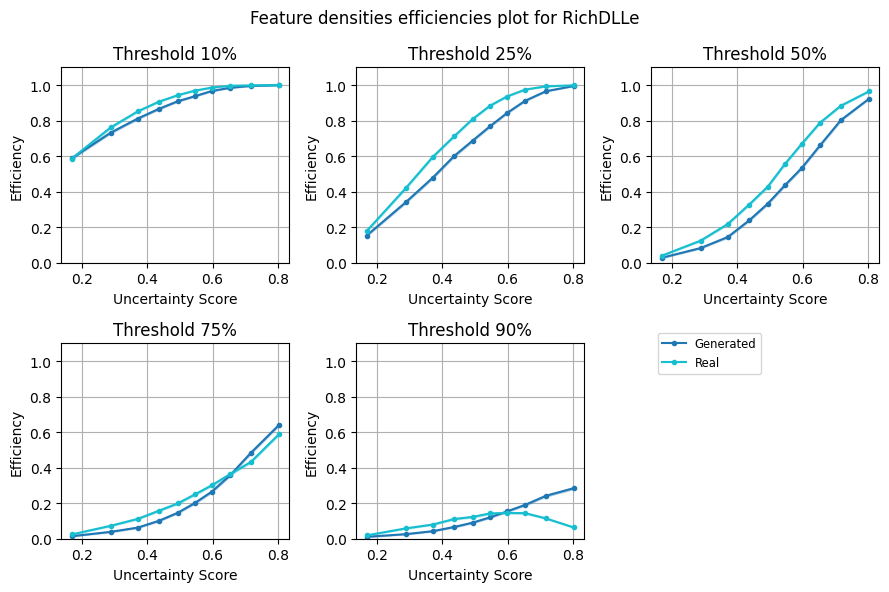

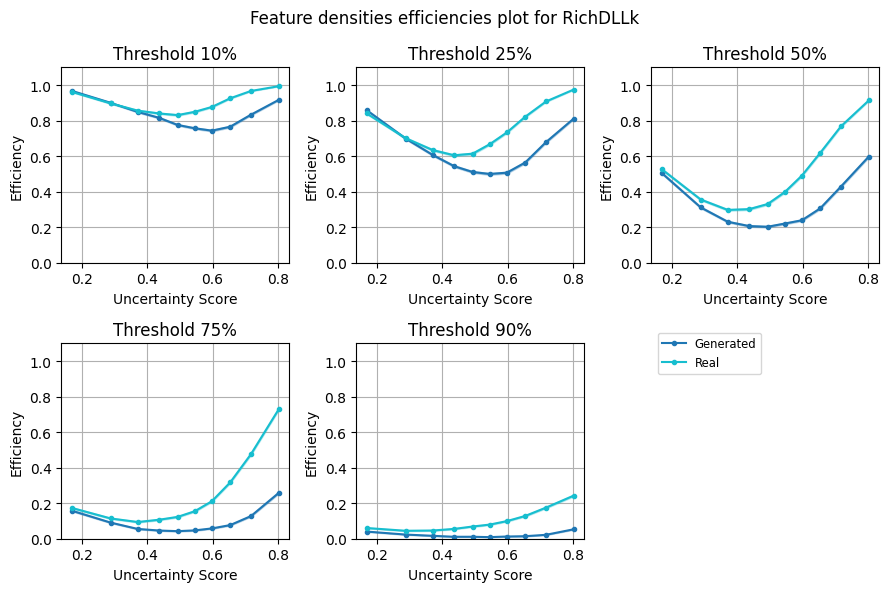

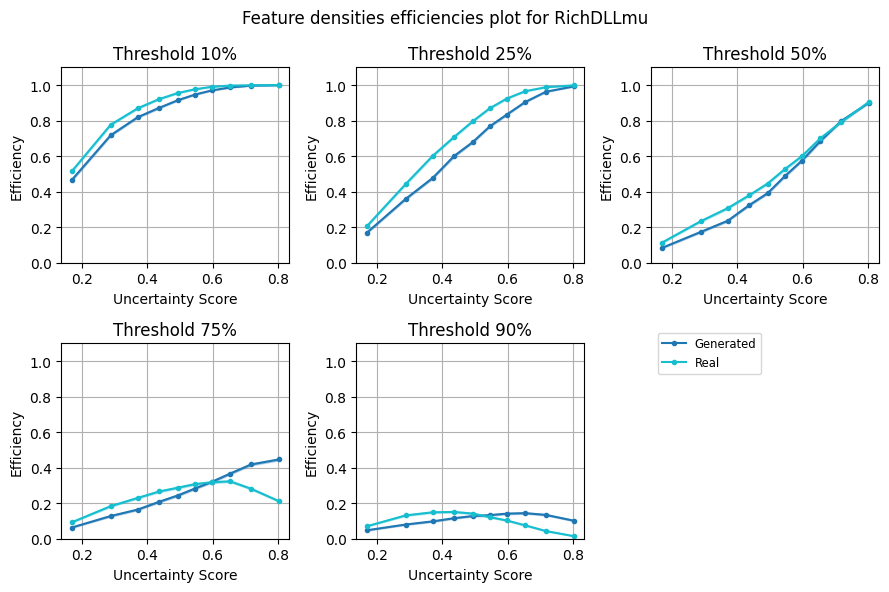

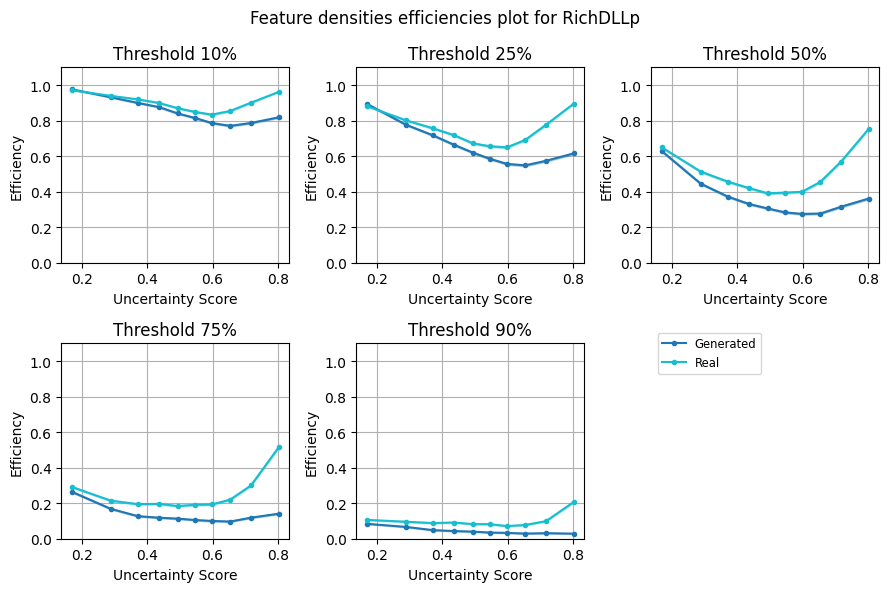

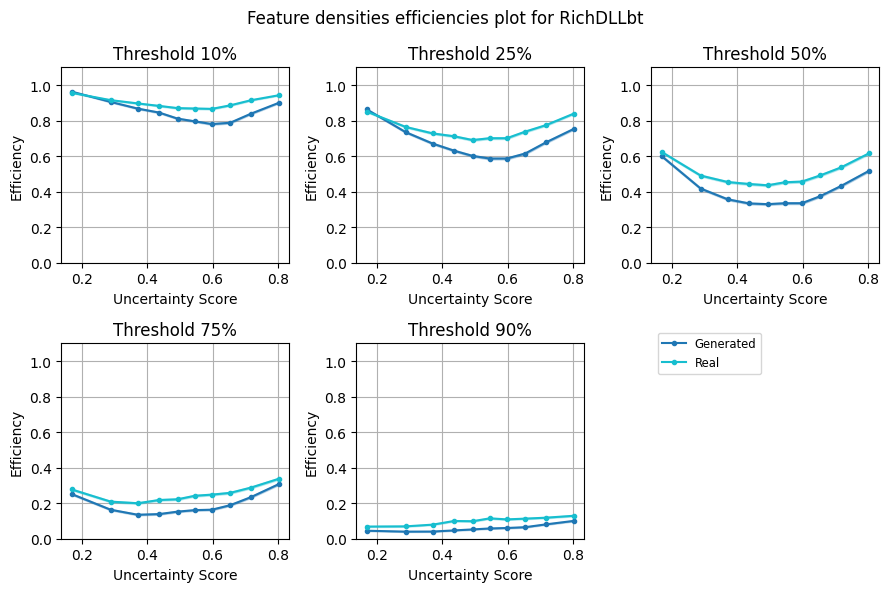

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, fd_uncertainty_normalized, [.1, .25, .5, .75, .9], "Feature densities", i)

### Plot MCD uncertainties

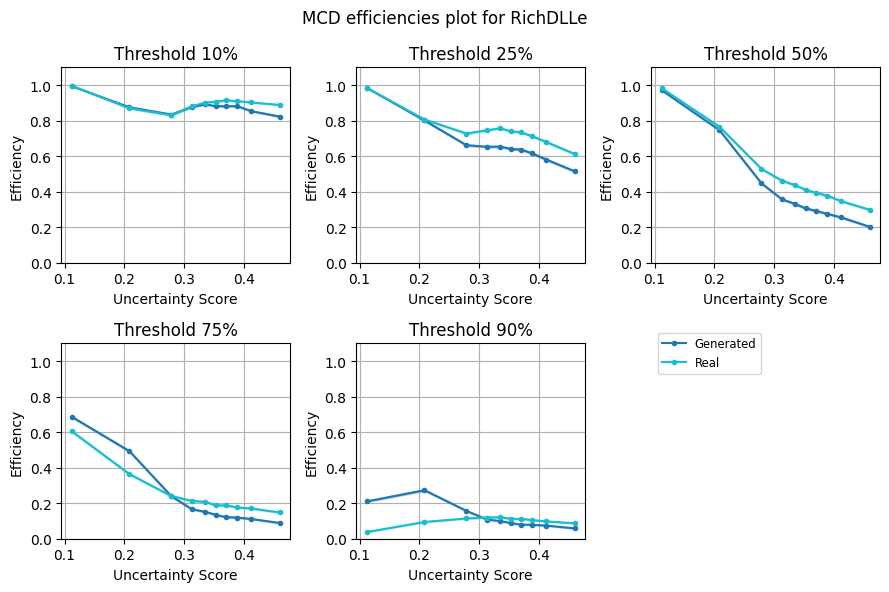

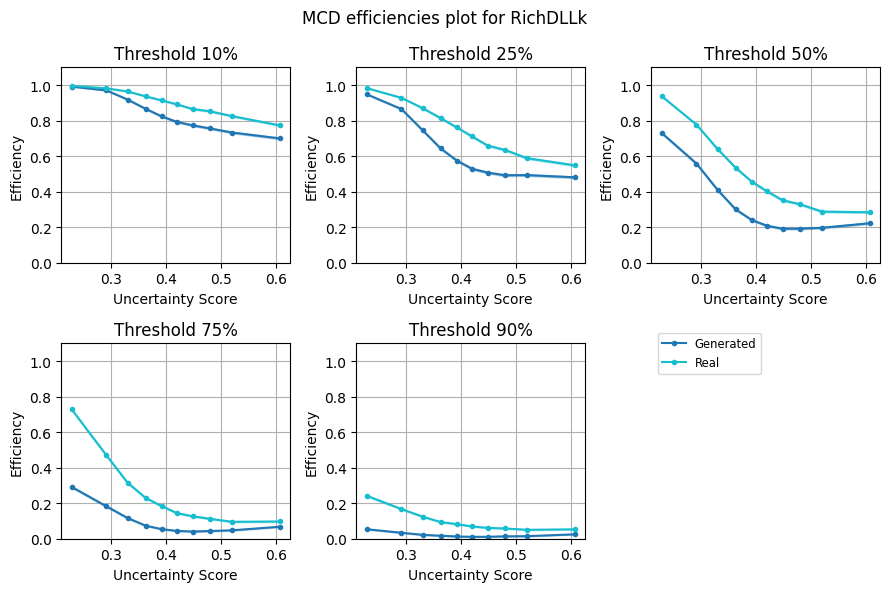

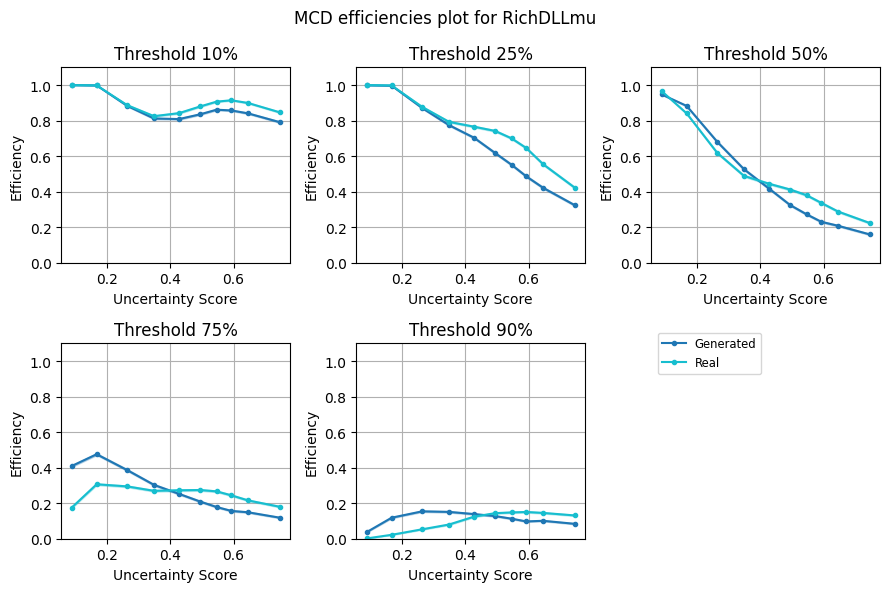

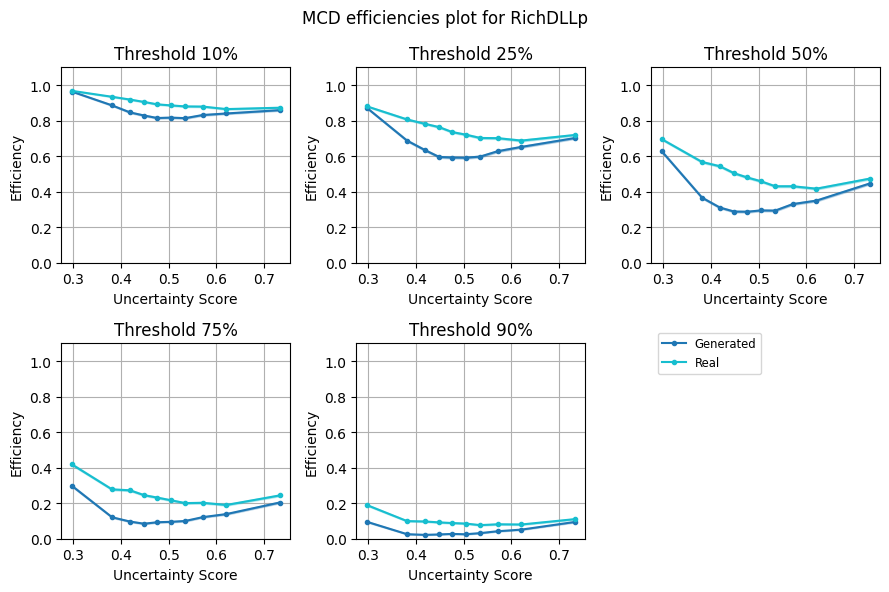

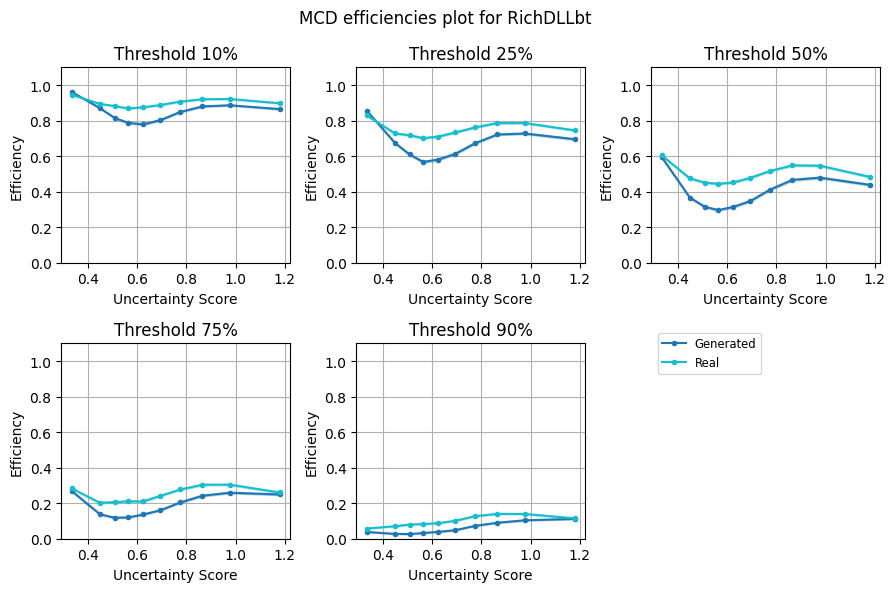

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, mcd_uncertainty, [.1, .25, .5, .75, .9], "MCD", i)

# Archived

#### FD with integration method


In [ ]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 9s 3ms/step
Estimating sample's feature densities


100%|██████████| 100000/100000 [09:40<00:00, 172.17it/s]


Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.99166736, 0.99320438, 0.98483132, ..., 0.98967961, 0.99608143,
       0.99588692])>

In [ ]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

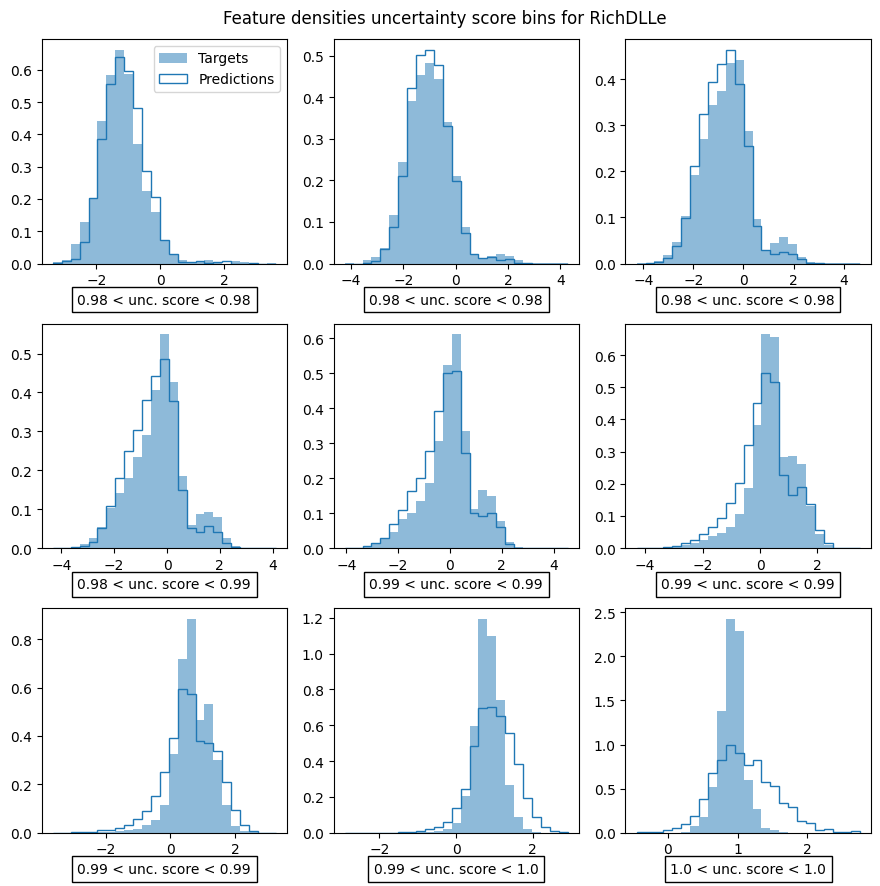

Jensen–Shannon distances:
0.09622084580538806, 0.0585183208196027, 0.07431106037785432, 0.09173176860875591, 0.09969241943001567, 0.1289956595370403, 0.1652380894043553, 0.23538475012621202, 0.37240579948854996


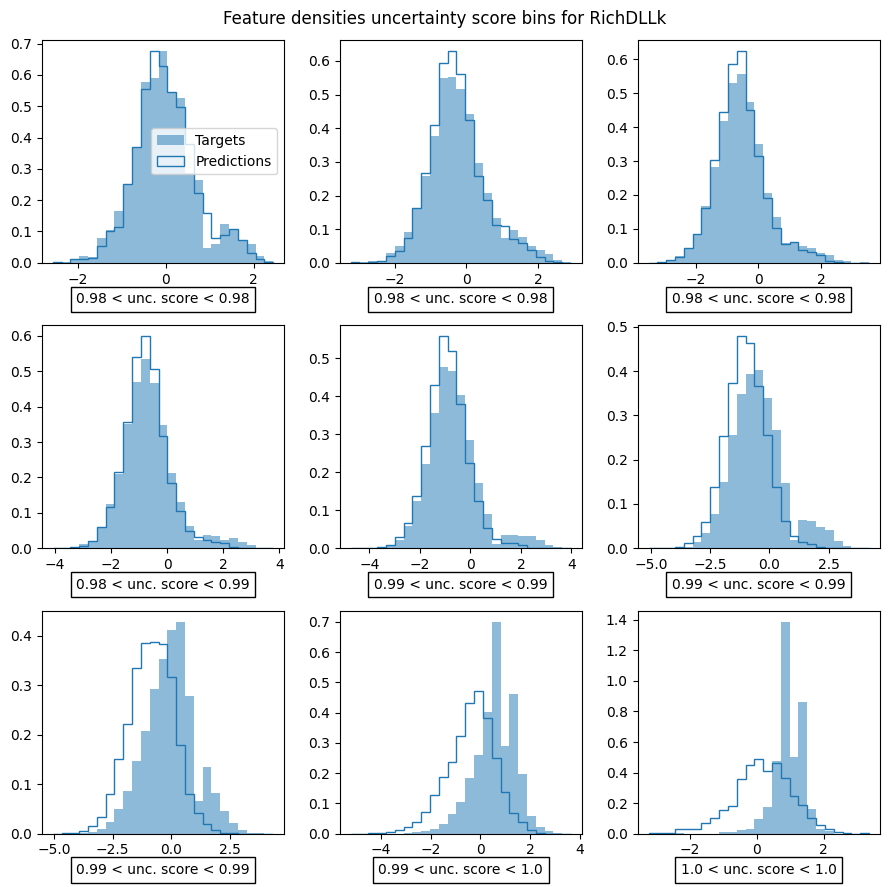

Jensen–Shannon distances:
0.08371077511448784, 0.0654720960520344, 0.05653954859424112, 0.08536574793440575, 0.12179464150396475, 0.19473439847731874, 0.27741588916878446, 0.36904235257402945, 0.4543678655925674


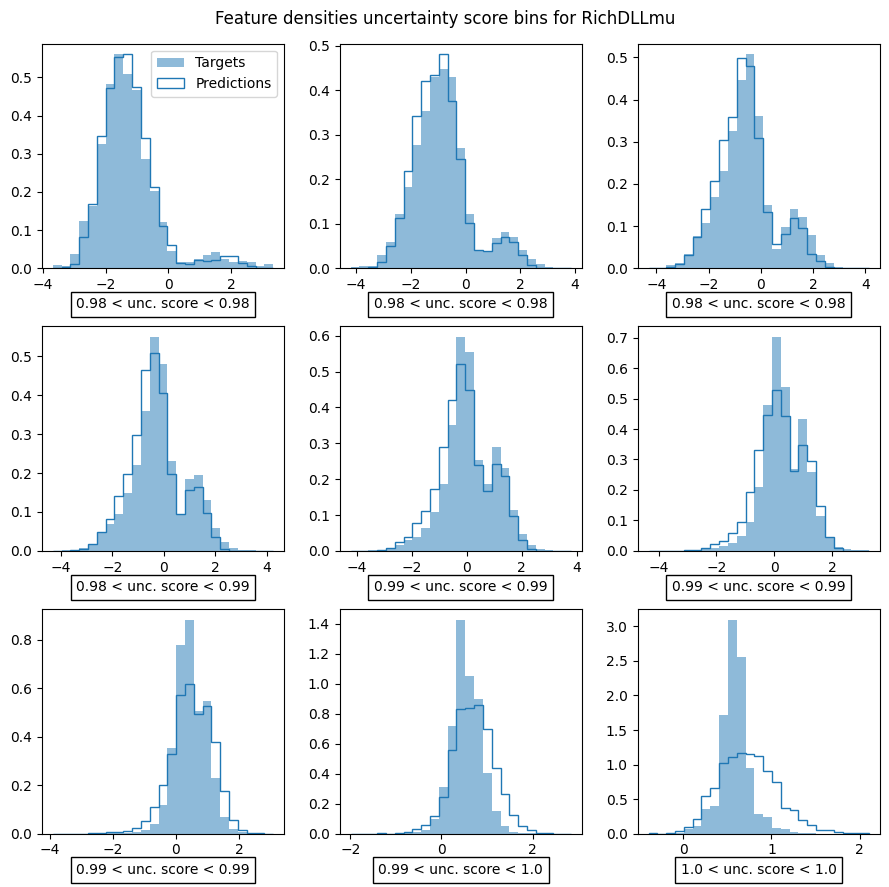

Jensen–Shannon distances:
0.08320841671858444, 0.06635888091019594, 0.08031478887903035, 0.08909623357918102, 0.09709237328152125, 0.11220610235831453, 0.14084113348506, 0.20008794857001014, 0.33758575031583343


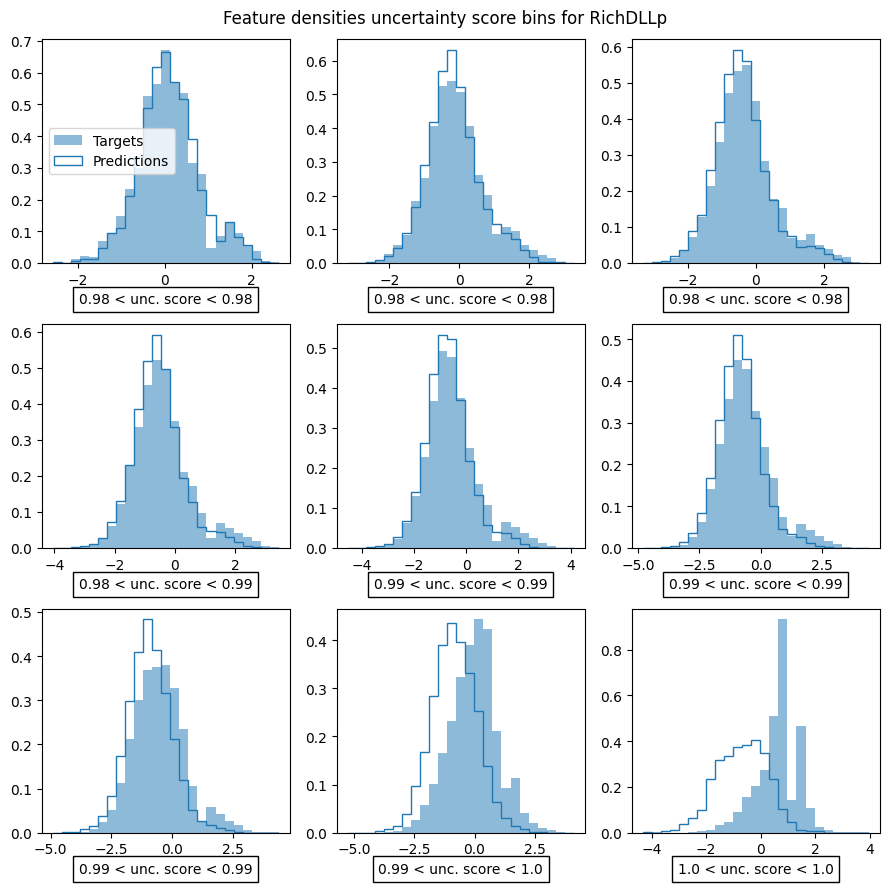

Jensen–Shannon distances:
0.07744682746742482, 0.06820153217264702, 0.07114998976382521, 0.08848384543658083, 0.09976903628186125, 0.1156986940602862, 0.15394968716591595, 0.28277369434794486, 0.49574636685905726


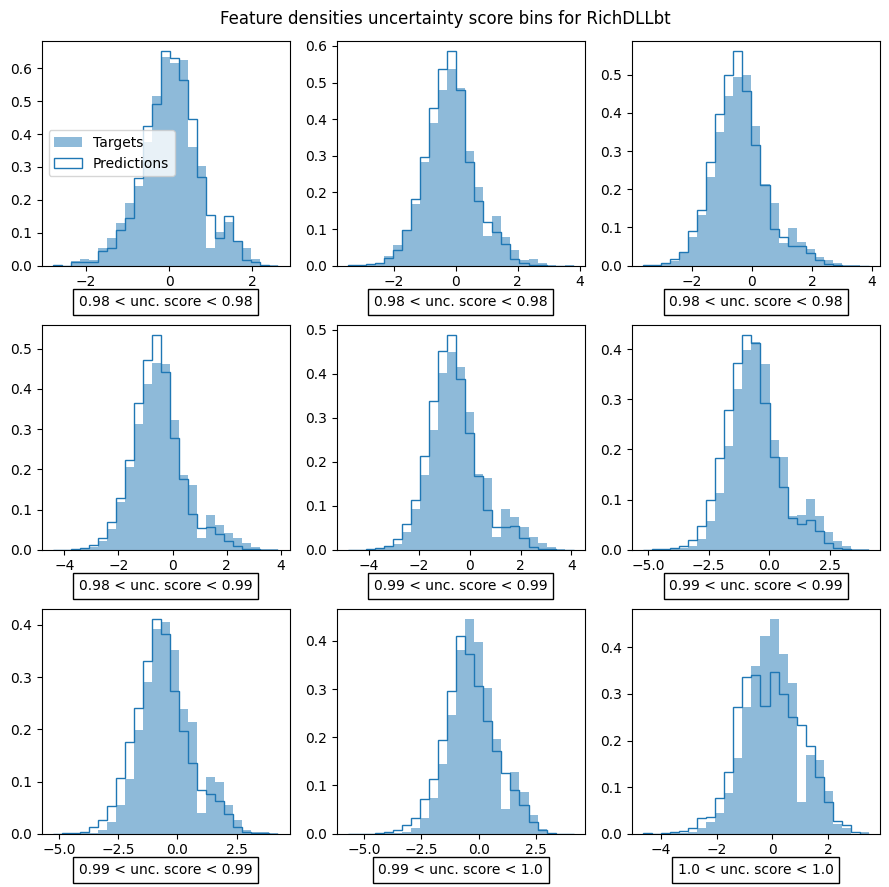

Jensen–Shannon distances:
0.08230790301719008, 0.07236818519397839, 0.07654665836042317, 0.09328260423021431, 0.104209952407771, 0.11565582126353942, 0.12169049182965685, 0.11879987567474574, 0.14639536458260857


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.845066837334593
Correlation coefficient for RichDLLk: 0.9224163337708419
Correlation coefficient for RichDLLmu: 0.825405229820007
Correlation coefficient for RichDLLp: 0.8058483879419905
Correlation coefficient for RichDLLbt: 0.9469326100625362


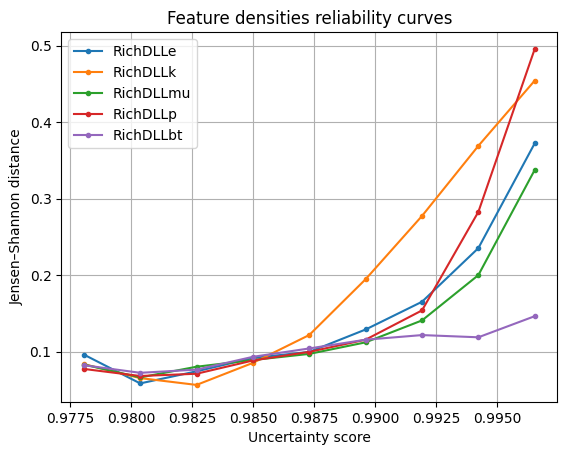

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)

In [ ]:
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

In [ ]:
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

In [ ]:
# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)